In [1]:
# PTT title generator from content base on seq2seq model.
import pandas as pd
import numpy as np
import csv
import os
import types 

#Initialize for files name and path.
base_dir = 'E:/Raw data/PTT'
totalboard_name = 'BG-CC-MV-SX-TJ-WT'
board_name = ['Boy-Girl','C_Chat','movie','sex','Tech_job','WomenTalk']
board_dict_index = {'Boy-Girl':0,'C_Chat':1,'movie':2,'sex':3,'Tech_job':4,'WomenTalk':5}

build_vocab = False
label_newnum = len(board_name)
max_word_length = 250+2
min_word_length = 100
max_push_length = 100+2
words_limit = 30000
filters_char='"#()*-/;[\]^_`{|}~\t\n'
#filters_char='ˊˋ#*×/\\^_`|＼﹨｜〝〞‵′＊／－-≦≧＿＃⌒‿．§◎˙※ㄧ↔│ꄊ✂☁☛✈♥○●☆★◇◆□■▽▼△▲㊣⊙⊕ˍ…﹌﹋﹎﹍﹉﹊‥–↑↓←→↖↗↙↘∥∕℅≒≡∩∪∞￣＿◤◥◣◢∵∴〒⊥∠⊿┼┴┬┤├▔─│▕┌┐└┘╭╮╰╯═╞╪╡╔╦╗╠╬╣╚╩╝╒╤╕╘╧╛╓╥╖╟╫╢╙╨╜║▓░▒╱╲╳▁━▶▁▂▃▄▅▆▇█▉▊▋▋▌▍▎▏▐▔■▁▔'

SOS_id = '<sos>' #解碼器端的句子起始標識符。
EOS_id = '<eos>' #解碼器端的句子結束標識符。
UNK_id = '<unk>' #低頻詞或者一些未遇到過的詞等。
PAD_id = '<pad>' #補全字符。

new_content_dir = []
new_push_dir = []
mdl_dir = os.path.join(base_dir, 'model')
if not os.path.exists(mdl_dir):
    os.makedirs(mdl_dir)
totalboard_dir = os.path.join(base_dir, totalboard_name)
if not os.path.exists(totalboard_dir):
    os.makedirs(totalboard_dir)
for name_ind in range(len(board_name)):
    # New data path
    new_content_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_content'))
    if not os.path.exists(new_content_dir[name_ind]):
        os.makedirs(new_content_dir[name_ind])
    new_push_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_push'))
    if not os.path.exists(new_push_dir[name_ind]):
        os.makedirs(new_push_dir[name_ind])

from keras.preprocessing.sequence import pad_sequences
from sklearn.cross_validation import train_test_split
import json

text_content = []
text_push = []

# Load PTT content and information.
dfs_total = pd.read_csv(os.path.join(totalboard_dir, totalboard_name + '.csv'))
len_total = len(dfs_total)

for dfs_index in range(len_total):
    read_index = int(dfs_total.iloc[dfs_index, 0])
    type_name = str(dfs_total.iloc[dfs_index, 1])
    word_length = int(dfs_total.iloc[dfs_index, 5])
    push_length = int(dfs_total.iloc[dfs_index, 6])
    title_name = str(dfs_total.iloc[dfs_index, 9])
    this_board_name = str(dfs_total.iloc[dfs_index, 10])
    
    # Add start and end character for content.
    text = SOS_id + ' '
    with open(os.path.join(new_content_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            for row in rows:
                # Read content and remove empty.
                text = text + row
        else:
            text = text + ' ' + EOS_id
    
    # Add start and end character for push.
    with open(os.path.join(new_push_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            # Read content and remove empty.
            for row in rows:
                # load only the first push text.
                push = SOS_id + ' ' + row + ' ' + EOS_id
                break
    
    text_content.append(text)
    text_push.append(push)

if build_vocab:
    from keras.preprocessing.text import Tokenizer
    # Build vocabulary and convert content to sequence by Keras tool.
    tokenizer = Tokenizer(num_words=words_limit, 
                          filters=filters_char,
                          lower=True,
                          split=" ")
                          #oov_token=UNK_word)
    tokenizer.fit_on_texts(text_content+text_push)
    vocab_sort = tokenizer.word_index
    vocab_counts = tokenizer.word_counts
    vocab_docs = tokenizer.word_docs

    print('Vocabulary size:', len(vocab_sort))
    vocab = {}
    vocab_reverse = {}
    vocab_keys = list(vocab_sort.keys())
    for vocab_word in vocab_keys:
        vocab_index = vocab_sort[vocab_word]
        if vocab_index <= words_limit+2:
            vocab_reverse[vocab_index] = vocab_keys[vocab_index-1]
            vocab[vocab_keys[vocab_index-1]] = vocab_index
            if vocab_index % 1000 == 0 or vocab_index < 100:
                print(vocab[vocab_word], vocab_word, vocab_reverse[vocab_index], 
                      vocab_counts[vocab_word], vocab_docs[vocab_word])
    else:
        #vocab[SOS_id] = words_limit + 1
        #vocab_reverse[words_limit + 1] = SOS_id
        #vocab[EOS_id] = words_limit + 2
        #vocab_reverse[words_limit + 2] = EOS_id
        vocab[UNK_id] = words_limit + 3
        vocab_reverse[words_limit + 3] = UNK_id

    # Save vocabulary information.
    with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_sort))
    with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_counts))
    with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_docs))
    with open(os.path.join(totalboard_dir, 'vocab.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab))
    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_reverse))
else:
    # Load vocabulary information.
    with open(os.path.join(totalboard_dir, 'vocab.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_reverse = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_sort = eval(f_text.read())
    #with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'r', encoding='utf-8-sig') as f_text:
        #vocab_counts = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_docs = eval(f_text.read())
    vocab_size = len(vocab)

    # Build vocabulary and convert content to sequence by Keras tool.
    # Convert texts list to sequences list.
    def texts_to_sequences(text_list):
        sequences_list = []
        for text in text_list:
            words = text.split(' ')
            sequence = []
            for word in words:
                if filters_char.find(word)>=0:
                    continue
                elif word in vocab:
                    sequence.append(vocab[word])
                else:
                    sequence.append(vocab[UNK_id])
            sequences_list.append(sequence)
        return sequences_list

# Build vocabulary and convert content to sequence by Keras tool.
x_train, x_test, y_train, y_test = train_test_split(text_content, text_push, test_size=0.2, random_state=9487)

# 將單字轉換成字庫的索引值
if build_vocab:
    x_train_word_ids = tokenizer.texts_to_sequences(x_train)
    x_test_word_ids = tokenizer.texts_to_sequences(x_test)
    y_train_word_ids = tokenizer.texts_to_sequences(y_train)
    y_test_word_ids = tokenizer.texts_to_sequences(y_test)
else:
    x_train_word_ids = texts_to_sequences(x_train)
    x_test_word_ids = texts_to_sequences(x_test)
    y_train_word_ids = texts_to_sequences(y_train)
    y_test_word_ids = texts_to_sequences(y_test)
# 序列模式
x_train = pad_sequences(x_train_word_ids, maxlen=max_word_length, padding='post', truncating='post')
x_test = pad_sequences(x_test_word_ids, maxlen=max_word_length, padding='post', truncating='post')
y_train = pad_sequences(y_train_word_ids, maxlen=max_push_length, padding='post', truncating='post')
y_test = pad_sequences(y_test_word_ids, maxlen=max_push_length, padding='post', truncating='post')
np.minimum(x_train, vocab[UNK_id], x_train)
np.minimum(x_test, vocab[UNK_id], x_test)
np.minimum(y_train, vocab[UNK_id], y_train)
np.minimum(y_test, vocab[UNK_id], y_test)
# 序列長度
x_train_size = np.clip([len(word_ids) for word_ids in x_train_word_ids], 0, max_word_length)
x_test_size = np.clip([len(word_ids) for word_ids in x_test_word_ids], 0, max_word_length)
y_train_size = np.clip([len(word_ids) for word_ids in y_train_word_ids], 0, max_push_length)
y_test_size = np.clip([len(word_ids) for word_ids in y_test_word_ids], 0, max_push_length)

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


INFO:tensorflow:Restoring parameters from E:/Raw data/PTT\model\PTT_Words_Embedding_1526955724.200002\model-60
Embeddings lookup shape:  (30004, 300)
INFO:tensorflow:Restoring parameters from E:/Raw data/PTT\model\PTT_vector2word_1527011689.9644923\model-60

epoch1
Iteration 1(0.07%); run time: 9[s]
Iteration 75(5.0%); run time: 244[s]
Iteration 150(10.0%); run time: 467[s]
Iteration 225(15.0%); run time: 684[s]
Iteration 300(20.0%); run time: 911[s]
Iteration 375(25.0%); run time: 1131[s]
Iteration 450(30.0%); run time: 1362[s]
Iteration 525(35.0%); run time: 1588[s]
Iteration 600(40.0%); run time: 1808[s]
Iteration 675(45.0%); run time: 2037[s]
Iteration 750(50.0%); run time: 2264[s]
Iteration 825(55.0%); run time: 2486[s]
Iteration 900(60.0%); run time: 2716[s]
Iteration 975(65.0%); run time: 2939[s]
Iteration 1050(70.0%); run time: 3157[s]
Iteration 1125(75.0%); run time: 3370[s]
Iteration 1200(80.0%); run time: 3595[s]
Iteration 1275(85.0%); run time: 3813[s]
Iteration 1350(90.0%)

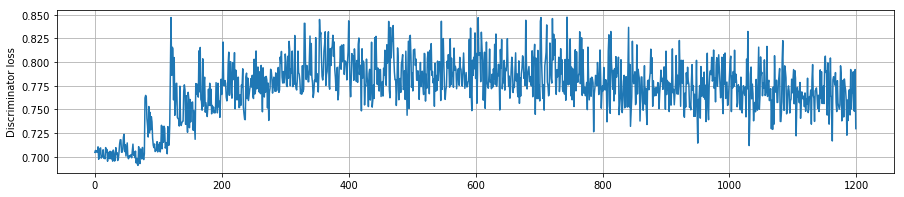

Train Generator Loss:  0.4877616801827682
Save the best generator score!! 0.4877616801827682


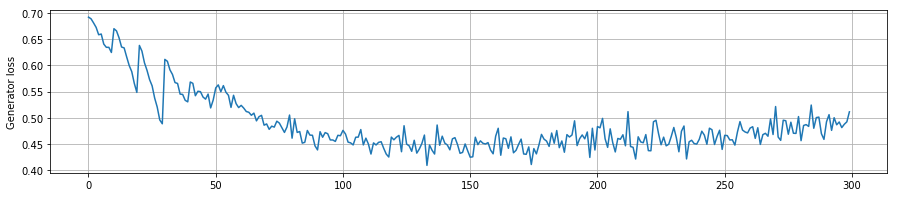

epoch 1 run to end!!
Target: <sos>解徽章任務xd突然感覺掉好多'‧ω‧'<eos> Return: 帥帥認識約炮一旦走動快轉高高友暴雷友交通
Target: <sos>好像很用心可是也沒有很萌的感覺<eos> Return: 快轉楊過程度近年來付帳出賣賭場加害者
Target: <sos>網站上要fpga最好設備用的到.<eos> Return: 勿彎彎鐵花賭場晴天
Target: <sos>暑假到了這種文真的好多r<eos> Return: 約炮程度約炮警匪再戰友友賭場反正星守者牙刷友ry美空
Target: <sos>同是過來人,狀況相似,加油.<eos> Return: 某騎兵seven賭場禁慾快轉天氣天氣脈昆特走動反正.只是脈
Target: <sos>之前不是曾經招呼出奧創來打人嗎有夠扯<eos> Return: 只想友東尼史塔克東歐vr受害人快轉付帳正向快轉
Target: <sos>加油下一個真的會更好<eos> Return: 走動唸書指示應該賭場友uncle戰將包個nasanasa無力快轉噠快轉包個友
Target: <sos>可以po笨板<eos> Return: 近幾年這時約炮走動鍊楠梓富翁約炮快轉
Target: <sos>英文忘了,中文好像叫歡喜<unk>cityofjoy<eos> Return: 閒話指示約炮約炮.只是友
Target: <sos>應該是心魔<eos> Return: 賭場愛爾蘭考上比得上反正反正劫出賣救台灣加害者友美空滑鼠武俠片美空美空反正反正全片腹救台灣美空腹反正ry友美空快轉快轉救台灣
Elapsed time in epoch 1: 4481 [s]

epoch2
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 211[s]
Iteration 150(10.0%); run time: 431[s]
Iteration 225(15.0%); run time: 649[s]
Iteration 300(20.0%); run time: 878[s]
Iteration 375(25.0%); run time: 1101[s]
Iteration 450(30.0%); run time: 

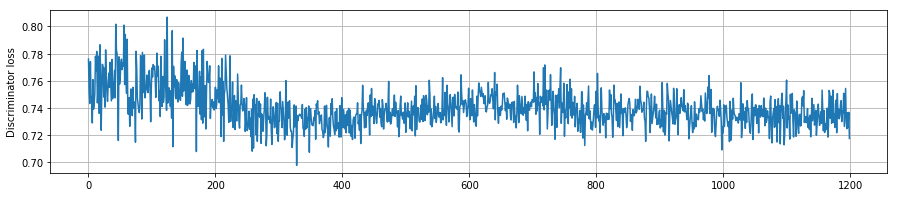

Train Generator Loss:  0.5327578363303964
Count early stop!! 1


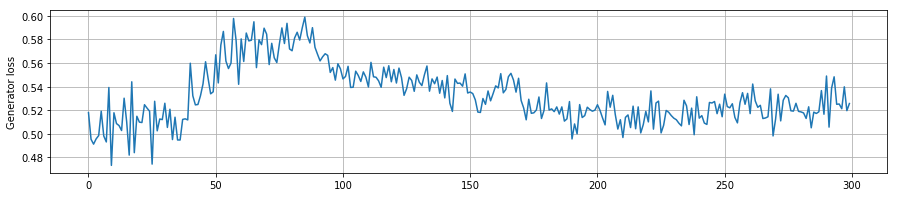

epoch 2 run to end!!
Target: <sos>要有一個目標阿,就像放暑假會希望趕快開學<unk>真的玩到不知道要玩什麼了很無聊.有目標的話退休去做自己喜歡的事情也沒關係<eos> Return: 保鏢女真梳子只想約炮的話約炮約炮天氣走動約炮反正約炮約炮約炮走動約炮
Target: <sos>好歹也問個<unk><eos> Return: 有家夠大鬆鬆亞斯約炮沖澡
Target: <sos>就<unk><unk>骯髒<unk><unk>噁賤貨性格使然阿.賤屌&婊屄<eos> Return: 賭場很爽同溫層反正晴天快轉神仙猜出反正限制
Target: <sos>看部門文化吧xd<eos> Return: 高崎程度友cvxdxd
Target: <sos>你法人定義怪怪的<eos> Return: 火鍋百種陰蒂友約炮成立走動
Target: <sos>很簡單啊.<eos> Return: 網小晴天丟去研所幫買友友
Target: <sos>2f好嗆xd<eos> Return: 只想作戰鎧手搖脈不理coding有誤教義不理走動反正約炮走動反正撞車走動反正
Target: <sos>重生殺機the<unk><eos> Return: 閒話梳子同音友撞車閒話救台灣閒話第三次反正資深美空反正走動
Target: <sos>晶電據說研替不補滿喔.記得問清楚<eos> Return: 課長成立扭轉賭場走動付帳友程度
Target: <sos>這是筆試通知吧<eos> Return: 定義英雄傳加害者快轉撞車梳子島上約炮救台灣撞車
Elapsed time in epoch 2: 4466 [s]

epoch3
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 224[s]
Iteration 150(10.0%); run time: 449[s]
Iteration 225(15.0%); run time: 674[s]
Iteration 300(20.0%); run time: 901[s]
Iteration 375(25.0%); run time: 1123[s]
Iteration 450(30.0%); run time: 1348[s]
Iteration 

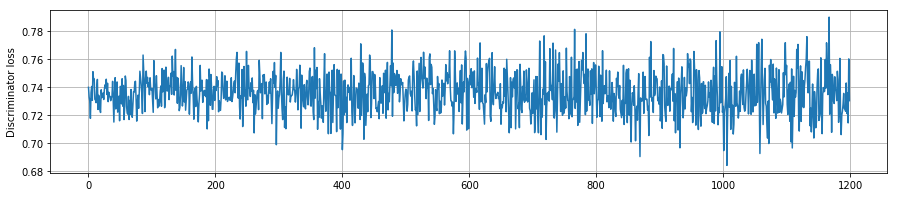

Train Generator Loss:  0.5438837677942877
Count early stop!! 2


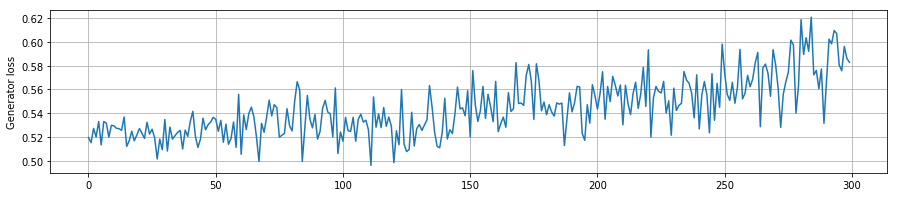

epoch 3 run to end!!
Target: <sos>小確幸?吃點甜的www<eos> Return: 陰蒂請留賭場加害者反正走動不理
Target: <sos>荷包蛋哪來的完美身材.<eos> Return: 快轉過活走動不理不理
Target: <sos>eva的基礎是動畫吧,漫畫只是<unk><eos> Return: 走動狀況重置走動網小鍊走動入門反正反正約炮
Target: <sos>狗鏡子那邊就被殺死<unk>沒死,最後還復活他男友,你有認真看嗎==<eos> Return: 入迷走動得利如何網小如何
Target: <sos>多做一些再談複合吧<eos> Return: 版得利課長友課長走動反正反正走動約炮走動走動走動反正走動救台灣
Target: <sos><unk>出了.謝謝大家<eos> Return: 本人梨程度走動一點不理走動反正
Target: <sos><unk>或黑<eos> Return: 沒改走動梳子網小不理撞車走動走動走動走動走動走動走動走動
Target: <sos>當初<unk>16變<unk>現在剩14了啊<eos> Return: 話撞車課長妨害風化不理友走動走動就爛走動走動走動走動走動走動
Target: <sos>不是有很多人從gg跳外商vendor嗎@@?<eos> Return: 薪張大哥約炮晴天不理不理不理友
Target: <sos>我也想.期待有人分享xd<eos> Return: 假奶撞車快轉張大哥梳子一點走動走動不理走動走動走動反正走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動走動反正走動走動走動
Elapsed time in epoch 3: 4497 [s]

epoch4
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 215[s]
Iteration 150(10.0%); run time: 432[s]
Iteration 225(15.0%); run time: 651[s]
Iteration 300(20.0%); run time: 872[s]
Iteration 375(25.0%); run time: 1093[s

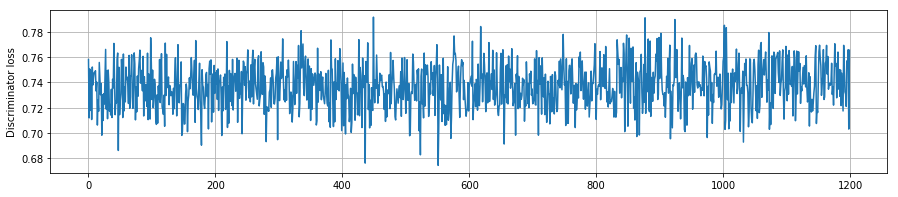

Train Generator Loss:  0.5858668674544383
Count early stop!! 3


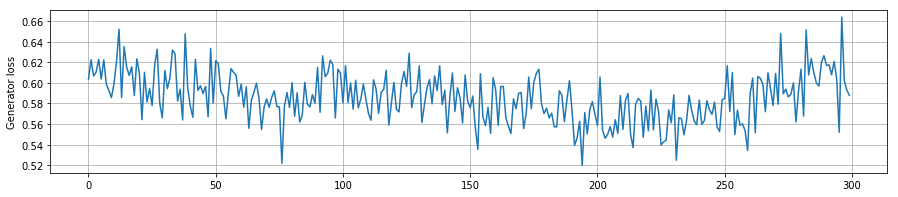

epoch 4 run to end!!
Target: <sos>好好大浴室有很多可以選.<eos> Return: 牙科牙科道理牙科四個載怪醫怪醫怪醫怪醫怪醫怪醫怪醫稱怪醫怪醫怪醫怪醫
Target: <sos>研替做rd才有價值<eos> Return: 那樣四個牙科pi道理急話會載用品四個典範四個怪醫怪醫怪醫怪醫怪醫典範
Target: <sos>他有試圖侵入核彈<unk>呀,但被老賈擋下來了而且說不定其他地方<unk>備份或生產分身,只是復仇者不知道<eos> Return: 年輪四個牙科道理道理怪醫四個怪醫
Target: <sos>一<unk>主顧<eos> Return: 牙科牙科教徒怪醫借來怪醫心靈東吳心靈
Target: <sos>我個人比較無法接受冷戰,寧願大吵一架在<unk><unk>好.但是其實是不要吵架最好,任何事都可以用討論的幹嘛<unk><eos> Return: 道理資格四個段時間怪醫怪醫銀魂怪醫
Target: <sos>我是男的a<unk>你沒多大興趣b君很難講搞不好是真的忙<eos> Return: 怪醫碁急銀魂走動載
Target: <sos>房間錢電費<eos> Return: 我玩過四個段時間道理牙科次郎保護惡魔怪醫急四個怪醫
Target: <sos>一定有的<eos> Return: 四個我玩過次郎四個怪醫載怪醫怪醫四個怪醫怪醫怪醫心靈典範怪醫怪醫
Target: <sos><unk>東東不錯嘛.蛤<eos> Return: 次郎道理次郎不至於道理急開刀怪醫保護急三國志急怪醫怪醫人太多怪醫
Target: <sos>程式寫的不用太感動<eos> Return: 打敗急藥丸四個段時間四個
Elapsed time in epoch 4: 4477 [s]

epoch5
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 220[s]
Iteration 150(10.0%); run time: 458[s]
Iteration 225(15.0%); run time: 681[s]
Iteration 300(20.0%); run time: 916[s]
Iteration 375(25.0%); run time: 1140[s]

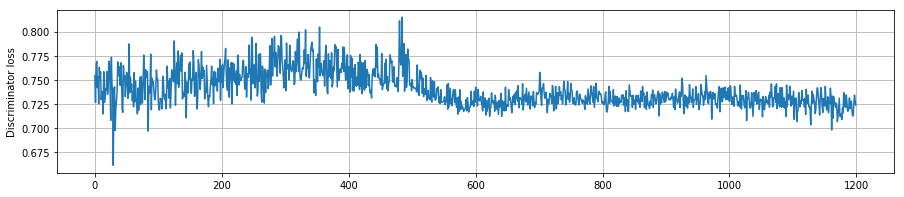

Train Generator Loss:  0.5771336817978184
Count early stop!! 4


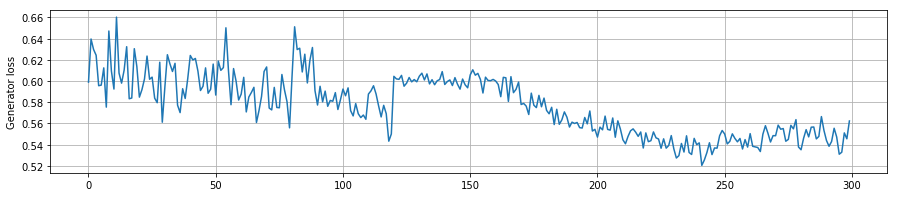

epoch 5 run to end!!
Target: <sos>看到開四個圈圈也滿驚訝的以為會是現代<eos> Return: ,後來夠本承認復甦復甦復甦復甦萌復甦復甦復甦復甦復甦復甦復甦復甦復甦
Target: <sos>超多!保養品<unk>涼鞋dw手錶<unk><eos> Return: 魔神圍棋處男復甦生殖復甦復甦sc復甦
Target: <sos>以前我也是這樣,後來每天用<unk>按摩機+熱敷,<unk>一下<eos> Return: 引人瞧westemail除掉處男復甦
Target: <sos>告白算嗎?用對方自己的計劃婊回去<eos> Return: 穴穴搖桿幫助太平太會ceo復甦
Target: <sos>薪水應該看學歷<unk><unk>簽約<unk>在<unk>聽說不能太'晚'走老人會不爽'說要一起閃<unk>就準時閃人但不知道每個廠是不是都一樣<eos> Return: 生殖選上印尼留著7
Target: <sos>轉型完之後會比較輕鬆嗎?本來吃相機就夠了.<eos> Return: 開頭除掉一面調整魔神
Target: <sos>我喜歡中東型的正妹,嘻嘻<eos> Return: 小朋友小朋友sclol復甦復甦sc復甦復甦復甦復甦復甦復甦
Target: <sos>你知道空虛公子嗎!<eos> Return: 玉米濃湯law穴穴復甦復甦復甦sc
Target: <sos>看是把參考層的<unk>厚度降低或是電鍍<unk><eos> Return: 不聞不問魔神白話愉快天大復甦復甦復甦復甦復甦
Target: <sos>輕鬆小品還不錯,看到目前,猜最後女主角的青梅竹馬發現女主角的美,女主角也慢慢改變對青梅竹馬的態度,兩個最後在一起<eos> Return: 網遊女主魔神推樓生殖
Elapsed time in epoch 5: 4447 [s]

epoch6
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 217[s]
Iteration 150(10.0%); run time: 428[s]
Iteration 225(15.0%); run time: 649[s]
Iteration 300(20.0%); run time: 866[s]
It

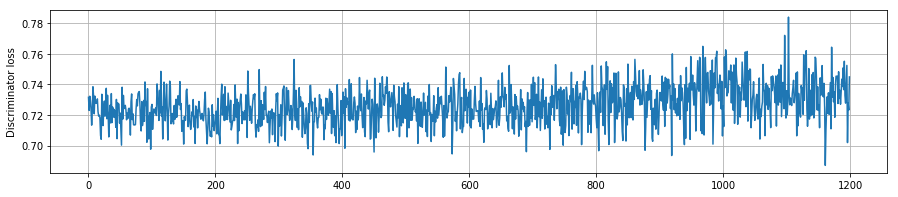

Train Generator Loss:  0.563548706724289
Count early stop!! 5


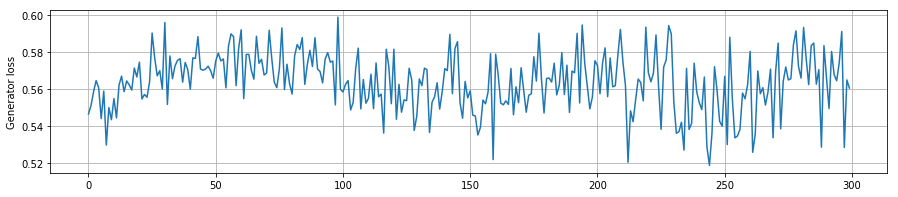

epoch 6 run to end!!
Target: <sos>這是上天注定的上天注定的最大<eos> Return: 毛茸茸一輩子佐證老婆婆共通同胞太平多久没有別一連串
Target: <sos>滿好笑的啊哈哈就很沒道理的好笑<eos> Return: 多種存錢差點瑪莉亞變冷玩命兩任憲哥線索漫漫
Target: <sos><unk>東東不錯嘛.蛤<eos> Return: 幫助關乎sc那一復甦多久考前相駕駛艙scbill漲價care空bill太平
Target: <sos>沒興趣,如果不排斥在旁邊滑手機只回答恩啊喔,可以<unk><eos> Return: 夠跳脫拍照一連串紀錄帥才帥才帥才帥才孬這片太平攝取多久非洲
Target: <sos>其實覺得<unk>得好奇附近的商家都不會困擾嗎?<eos> Return: 夠鋼索正版傑森多久討sc太平lol
Target: <sos>吃狗糧吃的好開心<eos> Return: email得宜穴穴感受一下太平多久多久還拍多久
Target: <sos>科學好像不太推<eos> Return: 水手服拍照宮老永遠都是守貞太平一粒憲哥改車bill
Target: <sos>殭屍浪很像z戰.虎頭蛇尾也很像orz<eos> Return: 沒料帥才毛茸茸拍照決定權毛茸茸
Target: <sos>有走輕鬆休閒風的酒吧,當然也有穿著有些性感的酒吧,看妳到底是去哪種酒吧?先打聽看看吧<eos> Return: 肉包竹東scsc大牌有個一輩子表格宮老中規中矩scsclol漫增貸考前emailbill除掉
Target: <sos>年輕a有年紀b<eos> Return: 孬光點守貞憲哥lol沒玩同胞
Elapsed time in epoch 6: 4397 [s]

epoch7
Iteration 1(0.07%); run time: 4[s]
Iteration 75(5.0%); run time: 217[s]
Iteration 150(10.0%); run time: 436[s]
Iteration 225(15.0%); run time: 659[s]
Iteration 300(20.0%); run time: 873[s]
Iteration 375(25.0%); run time: 1083[s]


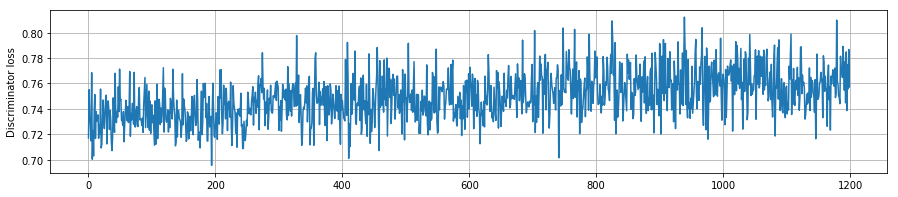

Train Generator Loss:  0.5403059870826796
Count early stop!! 6


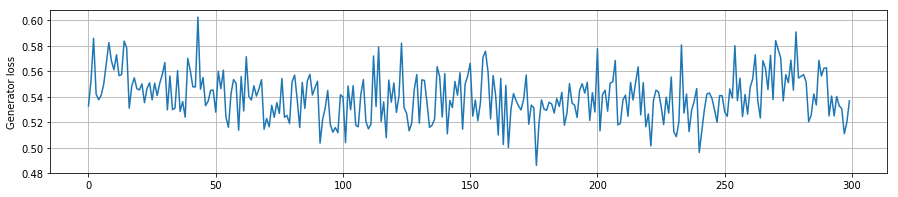

epoch 7 run to end!!
Target: <sos>你自己有答案了吧<eos> Return: 孬招財吃點某種正版鬥吸菸雷神雷神鬥
Target: <sos>能出去就趕快出去吧見<unk>也好<eos> Return: 開團憲哥甚至總統府mk吉普賽lol
Target: <sos>人家同意就拍<eos> Return: 黑道交際漲價沒玩小朋友別太平太平沒玩了點太平未眠太平玩命一連串玩命太平別
Target: <sos>聽說按摩多少可以變大一點<eos> Return: 玩命條件差點兵器皮膚科孬孬哀悼
Target: <sos>感覺她在打預防針了<eos> Return: 噓孤狗毛茸茸漲價差點孬漲價近視迷你
Target: <sos>中興百貨'誤'<eos> Return: 一輩子增貸懸疑片漲價一粒太空建中憲哥太平聚會別討厭倦增貸專精增貸增貸增貸增貸考前增貸相孬憲哥
Target: <sos>我有<unk>,主管說對新人非常要求@@<eos> Return: 滿身穴穴要學戰狼憲哥引來阻塞同學們孬玩命孬玩命太平多久玩命bill孬太平太平多久太平多久太平太平太平這片太平多久生疏太平
Target: <sos>爛不要去<eos> Return: 放錯遷就太平相相美少年
Target: <sos>是阿,差不多三小時三次<eos> Return: 非主流噴在他們噴在近視這片書法永遠都是攝取攝取
Target: <sos>傳產31k朝八晚五見紅就放勞保全薪中午<unk>離職xd<eos> Return: 雙北勞孬推樓室友同學們憲哥毛茸茸一連串飯
Elapsed time in epoch 7: 4401 [s]

epoch8
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 215[s]
Iteration 150(10.0%); run time: 443[s]
Iteration 225(15.0%); run time: 660[s]
Iteration 300(20.0%); run time: 883[s]
Iteration 375(25.0%); run time: 1099[s]
Iteration 450(30.0%); run time: 1318[s]
Iter

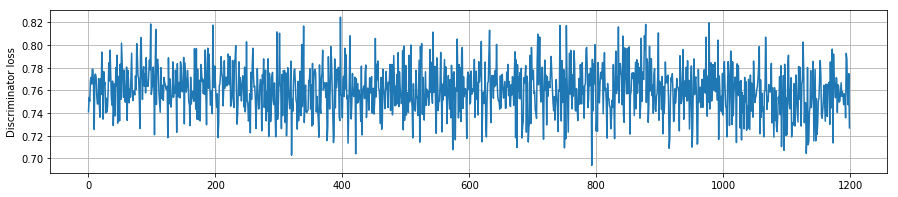

Train Generator Loss:  0.5515965282622729
Count early stop!! 7


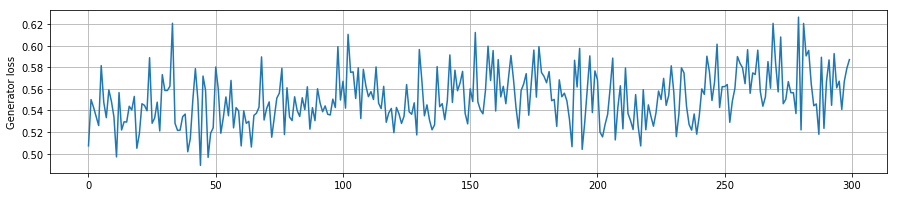

epoch 8 run to end!!
Target: <sos>你知道你剛才早餐吃的是動物和植物的<unk>嗎?還是<unk>的<eos> Return: 享有慶祝孬相差太空玩命
Target: <sos>這節目還蠻有趣的,之前大橋上的<unk>互動很好玩ww<eos> Return: 差點復健代言帥才推樓帥才長髮帥才玩命多久帥才正版帥才太平
Target: <sos>可以直接飛幹嘛要海底電纜<eos> Return: 學弟正版多久正版裡正版毛茸茸別孬
Target: <sos>好文!<unk>豪洨<eos> Return: 孬差點這型這型太平電影圈清醒綠帽
Target: <sos>鼻孔裡面痛!<eos> Return: 很甜跨憲哥文就太平
Target: <sos>你跟我同梯啊我同梯就一個這樣xd<eos> Return: 純愛下來多久噴在漲價孬帥才那一孬孬皮膚科這片孬皮膚科太平全部孬孬孬別皮膚科孬漲價帥才孬漲價太平sc憲哥皮膚科皮膚科憲哥孬續集玩命漲價
Target: <sos>等他密<eos> Return: 四伏玩命正版18%正版永遠都是孬穴穴增貸多久帥才皮膚科修復沒玩孬孬相孬孬
Target: <sos>當然是阿現代社會又不像古早了<unk>差誰<unk><unk>你有辦法跟女生以後常見面不然木訥根本只有<unk>或是<unk>像金城武就又另當別論<eos> Return: 玩命深呼吸守貞那一孬考前多久同胞
Target: <sos>老實說真的沒啥劇情<eos> Return: 同胞一輩子上推孬沒喝孬孬漲價太平想試線索線索增貸相別多久
Target: <sos>我說真的,光是今天我起床到剛剛,已經至少10個女生<eos> Return: 聽覺完到對手戲簽到同學們賈修玩命孬孬宵夜文綠帽同學們考克太平
Elapsed time in epoch 8: 4401 [s]

epoch9
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 214[s]
Iteration 150(10.0%); run time: 436[s]
Iteration 225(15.0%); run time: 655[s]
Iteration 300(20.0%); run time: 872[s]

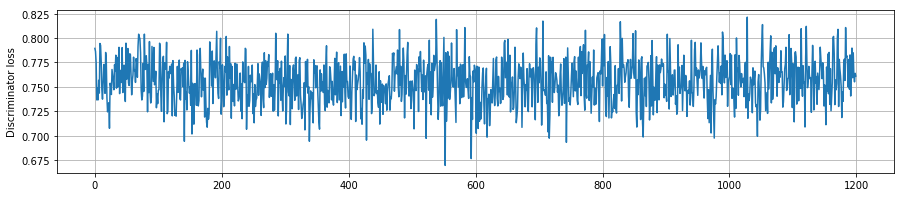

Train Generator Loss:  0.5819081316297127
Count early stop!! 8


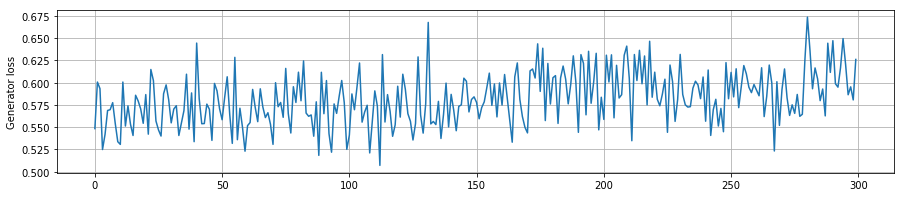

epoch 9 run to end!!
Target: <sos>又沒差他又不知道你是誰.且rank<unk>後就有階了所以之後'大致'上都是程度差不多的排<eos> Return: 奈米山根總統府賈修孬做好採取摸透皮膚科保安
Target: <sos>靠杯打錯腦子是想小魚<unk>?打出精子==<eos> Return: 還能大都會某種重逢採取皮膚科你賈修賈修
Target: <sos>正妹的有淡淡玫瑰香<eos> Return: 憲哥憲哥差點遮二休社會採取帥才oq採取加蛋
Target: <sos>你可以去港版電影版看看<eos> Return: 孬大都會保安摸透做好續集學分皮膚科線索續集續集線索
Target: <sos>現在是看臉色<unk>浮動<eos> Return: 孬奈米害人摸透非主流採取皮膚科保安續集保安
Target: <sos>那是<unk>魔杖.<eos> Return: 寄宿的可以孬保安保安更何況帥才保安孬續集密室
Target: <sos>限制發文篇數用意是什麼我也不懂.<eos> Return: oq相孬社會帥才這片相差續集
Target: <sos>我喝一杯就醉了<eos> Return: 有毒跨zack帥才點都帥才線索皮膚科續集皮膚科皮膚科爽續集皮膚科皮膚科續集皮膚科皮膚科續集續集續集續集續集
Target: <sos>我脖子比臉白,雖說臉都有在保養,大概是臉比較<unk>到<eos> Return: 莎莉賽隆威力威力賓士夠生害人皮膚科採取採取採取續集皮膚科續集孬續集
Target: <sos>這是哪一招xddd<eos> Return: 奈米差點玩命那一綠帽綠帽皮膚科
Elapsed time in epoch 9: 4401 [s]

epoch10
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 210[s]
Iteration 150(10.0%); run time: 435[s]
Iteration 225(15.0%); run time: 668[s]
Iteration 300(20.0%); run time: 892[s]
Iteration 375(25.0%); run time: 1102[s]
Iteration 450

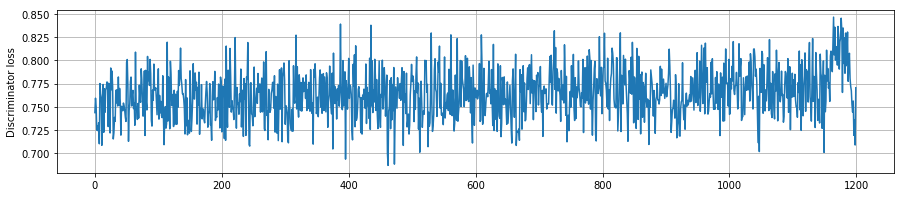

Train Generator Loss:  0.618068983989224
Count early stop!! 9


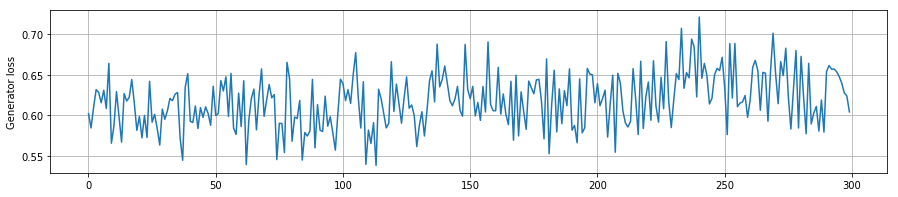

epoch 10 run to end!!
Target: <sos>慢慢投慢慢找吧.<eos> Return: 肉肉有什麼交友,擋箭牌,,按摩按摩爆棚爆棚,年輕,,
Target: <sos>木葉最強一族日向還在阿.大概<eos> Return: 小甜甜got在校,打包master鬥賣肉,,,,,動作,,,簽的,皇上擋箭牌擋箭牌洗簽的跳繩
Target: <sos>讚留言分享<eos> Return: 六無敵精力在校簽沒辦
Target: <sos>問紅茶<unk>,<unk>他的<unk>?<eos> Return: 六paul小甜甜很快當事人年輕爪爪年輕,,,,,波曼,,,年輕洗年輕,簽的,考試煮飯,打包皇上皇上,,,,,一話皇上血淋淋,,你問彼特<sos>皇上,,,年輕,,
Target: <sos>既然後面要寫n=22k了為啥不一開始<unk>薪資30k就好<eos> Return: 刪減認為配合,憤世嫉俗在校
Target: <sos>你是在<unk>?<eos> Return: 轟轟有分,,入珠在校貴婦那套,,,,,
Target: <sos>去看醫生<eos> Return: age配合飄過可以交友李奧納多神社自己
Target: <sos>如果劇情是醒醒吧你沒有妹妹應該會有很多人來<unk><eos> Return: 肉肉六在校李奧納多小太郎,,李奧納多爆棚李奧納多
Target: <sos>結果半夜又被叫去滅火,我被<unk>不要不要的,<unk>投降<unk>要深蹲跑步了xd<eos> Return: 簽跳繩小太郎涼宮春日神社餓到,怦然心動,,,餓到,,
Target: <sos>肯定不長久<eos> Return: 死因運動在校年輕大象,保鏢ig煮飯,,餓到master,擋箭牌餓到,
Elapsed time in epoch 10: 4390 [s]

epoch11
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 218[s]
Iteration 150(10.0%); run time: 435[s]
Iteration 225(15.0%); run time: 648[s]
Iteration 300(20.0%); run time: 876[s]


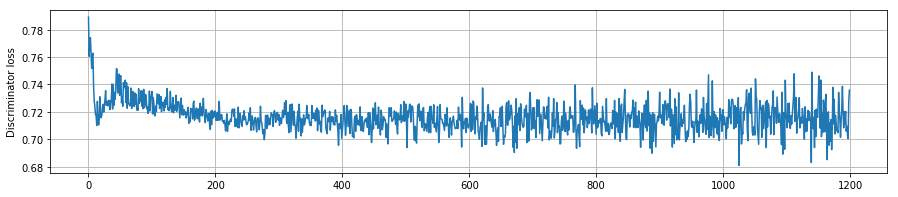

Train Generator Loss:  0.6149562746742847
Count early stop!! 10


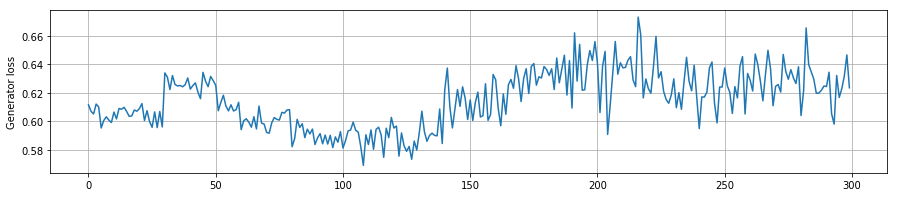

epoch 11 run to end!!
Target: <sos>真愛超讚!<eos> Return: 在校死因抹黑木端午端午
Target: <sos>第一年也是一半有沒有跟你也沒差啦<eos> Return: 英雄野豬整片管太多按摩端午設計師端午端午排卵期木端午
Target: <sos>我也蠻想看他打出<unk><unk>的感覺很潮<eos> Return: 毛毯會累得分差點白色端午排卵期死因英雄不吝指教英雄英雄英雄英雄英雄端午oct英雄
Target: <sos>先去a報到,等b拿到再跟a的主管請辭不適應之類的<eos> Return: 幾週權力排卵期維基木管太多木美味成本木端午美味海巡管太多
Target: <sos>肯定不長久<eos> Return: 故事性撐起來整團在校肉肉李奧納多肉肉英雄李奧納多木成本成本管太多age擋箭牌oct
Target: <sos>多麼痛的領悟<eos> Return: 木鬥肉肉內心深處直上age端午野豬端午
Target: <sos>通常是2週,等多久了?<eos> Return: 得分野豬幾週肉肉端午管太多端午端午端午端午端午木端午端午端午端午端午海巡,皆肉肉
Target: <sos>先幫你刪<unk><eos> Return: 管太多沒臉反應age端午端午英雄英雄權力英雄英雄端午
Target: <sos>看成金鋼<unk>代表啥<eos> Return: 故事性生age管太多木木成本木木
Target: <sos>覺得自己爛<unk>在批踢踢上推垃圾推文就不會被發現了<eos> Return: 鬥整片得分反應肉肉在校英雄管太多木英雄野豬,,端午
Elapsed time in epoch 11: 4402 [s]

epoch12
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 224[s]
Iteration 150(10.0%); run time: 443[s]
Iteration 225(15.0%); run time: 663[s]
Iteration 300(20.0%); run time: 890[s]
Iteration 375(25.0%); run time: 1113[s]
Iteration 450(3

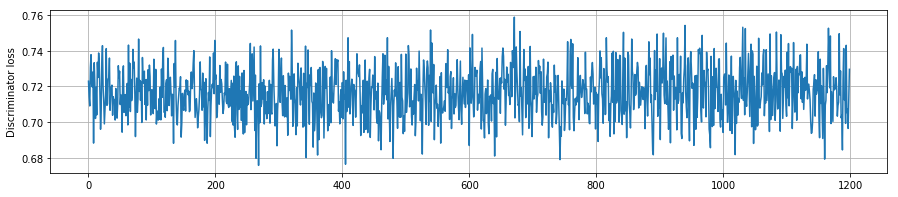

Train Generator Loss:  0.62015398967225
Count early stop!! 11


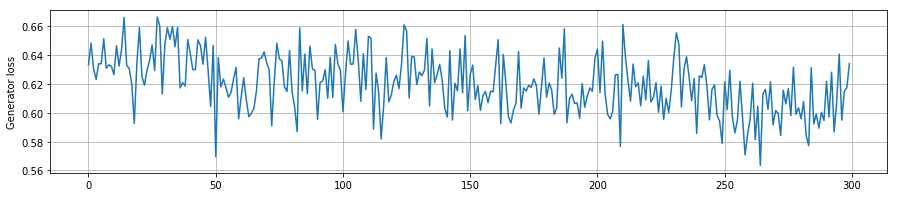

epoch 12 run to end!!
Target: <sos>跟他說給我肛我就幫你鑽<eos> Return: 你問幾根直上徐克的貓在校
Target: <sos><unk>的'<unk>'2012威尼斯<unk>'<eos> Return: 徐克還不是直上徐克徐克絲排卵期排卵期排卵期排卵期tmd揉海巡排卵期海巡海巡海巡海巡
Target: <sos>不是死掉,我覺得是說雖然受害者無辜受害且想<unk>起來,但社會旁人眼光還是<unk>在她身上,這點<unk><eos> Return: 不輕排卵期罪名排卵期絲
Target: <sos>先問為什麼交不到朋友.如果問題<unk>轉了也不見得交<unk>有可以改的就可以先嘗試<unk>有一些是衛生習慣不好身體臭頭髮髒,弄乾淨就好多了<eos> Return: 湯匙排卵期不輕女真tmd排卵期改革tmdtmd蛋糕tmd
Target: <sos>敢<unk>不好你要被某tony噓了<eos> Return: 排卵期很快排卵期木北科在校爆過慚愧慚愧排卵期腐敗慚愧排卵期
Target: <sos>不能,而且以後會很怕去<unk>吃飯<eos> Return: 排卵期熱身排卵期變形徐克美味徐克
Target: <sos>沒照片<unk><eos> Return: 身為排卵期故事性賣肉四人カ鬥legal爆過排卵期精力慚愧爪爪精力
Target: <sos>這集男女1表現都不錯嘛.有點小感動qq<eos> Return: 害人排卵期徐克兩層排卵期很快legal亂講排卵期幾根高層
Target: <sos>前提還是不能太歪<eos> Return: 親家噴在亂講排卵期噴在排卵期腐敗亂講排卵期腐敗亂講幾根
Target: <sos>送我吧我一定沒問題<eos> Return: 要切墮胎詹姆士蛋糕螢火蟲tmd大猩猩幾根
Elapsed time in epoch 12: 4456 [s]

epoch13
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 229[s]
Iteration 150(10.0%); run time: 446[s]
Iteration 225(15.0%); run time: 666[s]
Iteration 300(20

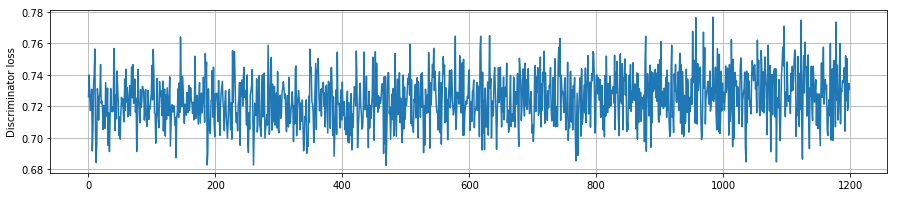

Train Generator Loss:  0.6160065694537534
Count early stop!! 12


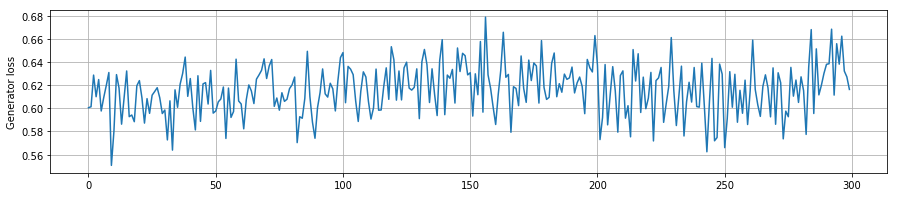

epoch 13 run to end!!
Target: <sos>3dimax就好了<eos> Return: 在校噴在湯匙精力甜蜜蜜慚愧慚愧排卵期腐敗腐敗精力多難亂講亂講海巡幾根
Target: <sos>這我可以報名中<eos> Return: 表象排卵期噴在legaltshirt排卵期最好tmdiphone
Target: <sos>先幫你刪<unk><eos> Return: 在校事件腐敗時會排卵期腐敗在校
Target: <sos>至少不會都棚拍.<eos> Return: 揉不輕大猩猩腐敗算是當事人生蛋最好慚愧排卵期幾根
Target: <sos>上輩子做壞事,這輩子做電視<eos> Return: 鬥排卵期在校最好在校文具排卵期legallegal排卵期tmd海巡慚愧點都精力海巡
Target: <sos>兩個人穿同一條內褲,好像很<unk>,其實爽歪歪.'<unk><unk>.'<eos> Return: 天線吸引力腐敗地震最好湯匙甜蜜蜜腐敗腐敗精力熱身熱身女真miku腐敗
Target: <sos>肚子好餓<eos> Return: 排卵期排卵期第二天腐敗亂講各種腐敗
Target: <sos>我也是<unk>就出,但還是莫名空虛<eos> Return: 甜蜜蜜簽的湯匙韌體鬥蛋糕在校腐敗腐敗爪爪幾根
Target: <sos>小的沒感覺,真可憐<eos> Return: 磁鐵被子酒害人相等最好
Target: <sos>幹我崩潰了<eos> Return: 意志生蛋不輕腐敗精力亂講相等
Elapsed time in epoch 13: 4472 [s]

epoch14
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 219[s]
Iteration 150(10.0%); run time: 449[s]
Iteration 225(15.0%); run time: 670[s]
Iteration 300(20.0%); run time: 891[s]
Iteration 375(25.0%); run time: 1116[s]
Iteration 450(30.0%); run time: 1344[s]
Iteration 525(35.0%);

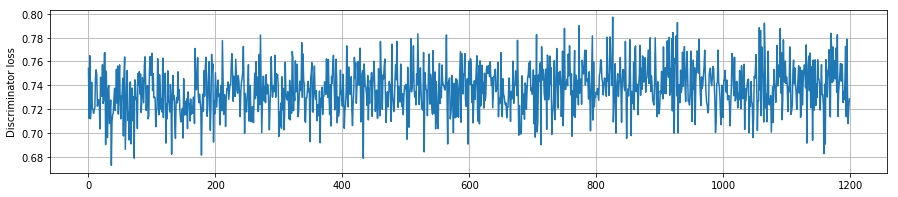

Train Generator Loss:  0.621683102496403
Count early stop!! 13


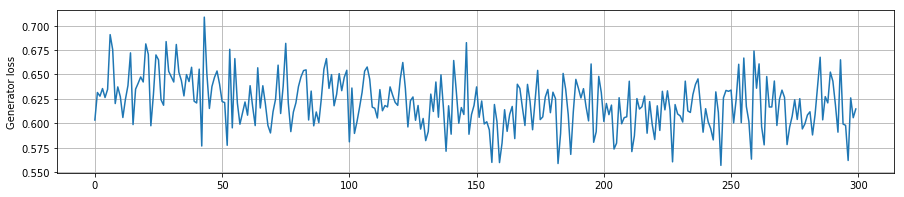

epoch 14 run to end!!
Target: <sos>辦手機也要<unk>證件.<eos> Return: 不輕理性平安夜叫野蠻克林拔出螢火蟲
Target: <sos>下次背九九乘法表,'<eos> Return: 蛋糕徐克湯匙有分凱格爾現狀
Target: <sos>棍又是這種問題煩不煩阿<eos> Return: 升遷湯匙巴利維基亂講排卵期談完
Target: <sos>這麼爛的cg加上沒內容的預告.<eos> Return: 生蛋速速不輕生蛋徐克壽命對抗00海巡排卵期
Target: <sos>五樓聞到大便味就硬了,你說呢?<eos> Return: 亂講amazon不太鬥三件
Target: <sos>推這篇最中肯不管學歷多高男人終究是<unk>po好像也沒很高拍謝<eos> Return: 很愛的亂講腐敗會放早點禁臠腐敗
Target: <sos>是基本禮貌吧.至少我這麼認為<eos> Return: 交際簽的排卵期磁鐵那裏潤滑液排卵期
Target: <sos>呃低<unk>?<eos> Return: 亂講亂講有把握相等蛋糕蛋糕腐敗排卵期
Target: <sos>啊.我的意思是電影裏的主角.<eos> Return: 直上一球韌體有玩過精力芝麻官腐敗芝麻官腐敗很快甜蜜蜜精力
Target: <sos>約看看吧<eos> Return: 不輕排卵期抹黑亂講腐敗僅慚愧腐敗程式
Elapsed time in epoch 14: 4460 [s]

epoch15
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 218[s]
Iteration 150(10.0%); run time: 447[s]
Iteration 225(15.0%); run time: 661[s]
Iteration 300(20.0%); run time: 883[s]
Iteration 375(25.0%); run time: 1105[s]
Iteration 450(30.0%); run time: 1336[s]
Iteration 525(35.0%); run time: 1557[s]
Iteration 600(40.0%); run time: 17

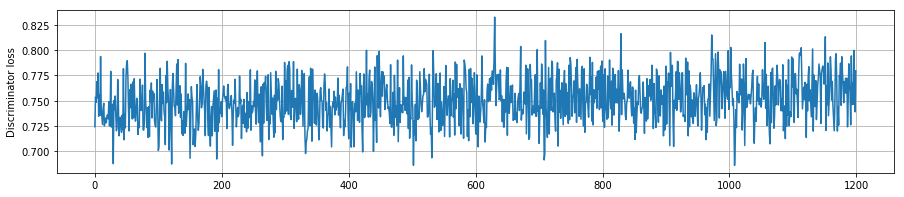

Train Generator Loss:  0.6051670191649076
Count early stop!! 14


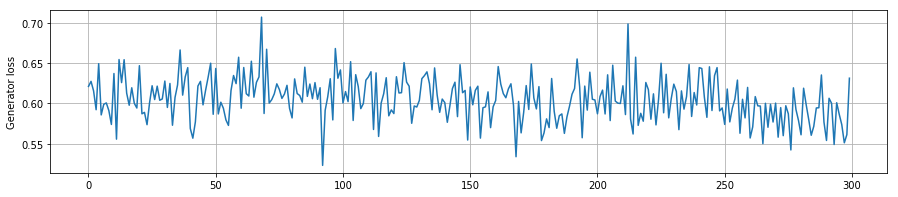

epoch 15 run to end!!
Target: <sos>我反而想看噴黃色的xd<eos> Return: 排卵期唬爛鬥女真爆死時會排卵期腐敗鴿子夜魔俠排卵期排卵期排卵期
Target: <sos>蛤我很喜歡<unk>聽到小幸運和五月天的口水<unk>跳過<eos> Return: 儲備只靠促銷抑或會放腐敗腐敗腐敗高層亂講亂講熱身亂講湯匙sp精力幾根阻擋爪爪戰狼亂講幾根慚愧慚愧要算戰狼爪爪tmd亂講早點幾根幾根亂講幾根幾根幾根幾根女孩兒要算爪爪幾根
Target: <sos>不做單機嗎qaq<eos> Return: 傻妹還不是萬出頭同理竿子
Target: <sos>尻完就睡了想那麼多你不累啊?<eos> Return: 未眠放慢大腳腐敗but排卵期真不知道真不知道排卵期
Target: <sos>我想到某次做到一半男生說他快抽筋了xddd<eos> Return: 亂講亂講排卵期簽的排卵期排卵期亂講排卵期tmd所以才腐敗腐敗
Target: <sos>寶寶是小三<eos> Return: 平安夜排卵期擋箭牌排卵期九族簽的壽命精力傘
Target: <sos>這麼奴加好加滿只為錢<eos> Return: 詹姆士熱身帶有擴張蛋糕爆過排卵期蛋糕可夫腐敗音調tmd排卵期
Target: <sos>你不懂幹正妹的成就感<eos> Return: legal妹仔抑或推動三件生蛋亂講
Target: <sos>阿凡達'誤<eos> Return: 1025徐克幾根蛋糕最好
Target: <sos>一起打電動<eos> Return: 做愛時排卵期交際做愛時外表排卵期禁臠亂講排卵期幾根禁臠亂講何亂講慚愧獵鷹慚愧亂講亂講亂講亂講慚愧排卵期亂講慚愧tmd亂講排卵期ios排卵期幾根
Elapsed time in epoch 15: 4484 [s]

epoch16
Iteration 1(0.07%); run time: 3[s]
Iteration 75(5.0%); run time: 217[s]
Iteration 150(10.0%); run time: 443[s]
Iteration 225(15.0%); run time: 661[s]
Iteration 300(20.0%); run time: 881[s]
Iteration 375(

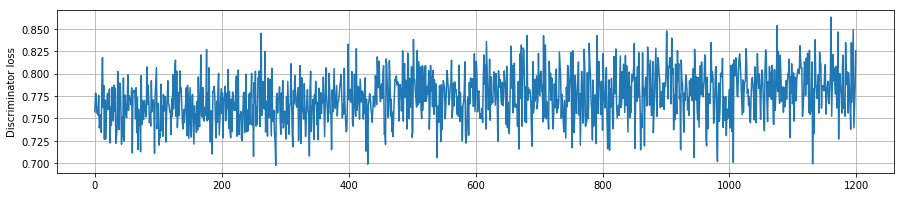

Train Generator Loss:  0.6100741183277364
Count early stop!! 15


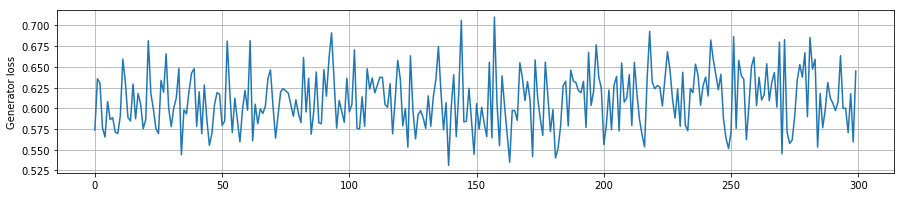

epoch 16 run to end!!
Target: <sos>不一定吧,對自己有信心一點<eos> Return: blog大猩猩直上排卵期鬥鬥重訓
Target: <sos>還好我實力100領400<eos> Return: 還不是蛋糕げ兩地甜蜜蜜湯匙排卵期伊甸園tshirt最好甜蜜蜜甜蜜蜜
Target: <sos>佐助我的其他隨便<eos> Return: 排卵期排卵期打個詹姆士排卵期傘慚愧腐敗中東潤滑液慚愧慚愧排卵期幾根慚愧爪爪慚愧慚愧tmd幾根幾根
Target: <sos>是要問幾次啦?要裝快點裝<eos> Return: 同理不輕大猩猩馬路排卵期軌跡腐敗還不是tmd
Target: <sos>可以不要見面了嗎=?<eos> Return: 這套噴在有肉開始開始排卵期中後期
Target: <sos>好好愛護他關懷他這麼臭的肥宅很稀有<eos> Return: 腐敗腐敗腐敗腐敗大猩猩反殺
Target: <sos>開掛中二畫面詭異爆笑.有點<unk>.還可以但又不能配飯吃w<eos> Return: 相等排卵期徐克聽覺亂講排卵期相等
Target: <sos>第二句也太驚悚'?<eos> Return: 幾代排卵期在校傻妹外省兩地腐敗湯匙幾根慚愧幾根慚愧排卵期慚愧
Target: <sos>會,丹丹我都想從第一項點到最後一項<eos> Return: 很快還不是蛋糕在校簽的腐敗爆過蘆薈
Target: <sos>可能會有人寄信給女生<unk>吧.<eos> Return: 戰術精力徐克滿街不輕吸引力爪爪爪爪排卵期徐克爆過相等慚愧點都tmd
Elapsed time in epoch 16: 4490 [s]

epoch17
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 216[s]
Iteration 150(10.0%); run time: 444[s]
Iteration 225(15.0%); run time: 663[s]
Iteration 300(20.0%); run time: 891[s]
Iteration 375(25.0%); run time: 1113[s]
Iteration 450(30.0%); run time: 1343

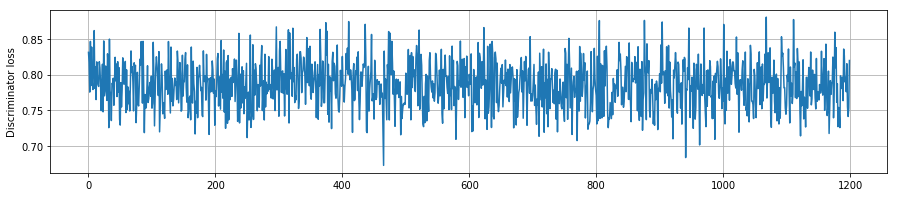

Train Generator Loss:  0.6618621146517388
Count early stop!! 16


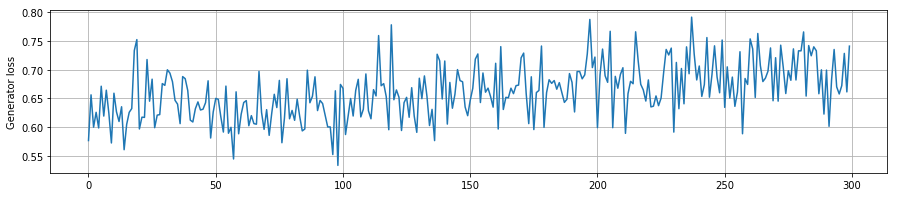

epoch 17 run to end!!
Target: <sos>我以為在低卡<eos> Return: 還不是white排卵期運鏡慚愧排卵期亂講亂講精力腐敗腐敗精力tmd
Target: <sos>對!就是這一部超開心的多謝<eos> Return: 鬥排卵期排卵期排卵期鬥在校
Target: <sos>做wifi的都很熟吧iq系列<eos> Return: 這種中指大猩猩排卵期在校三明治
Target: <sos>生小孩前互換www<eos> Return: 相等在校排卵期直上相等鬥慚愧tmd湯匙
Target: <sos><unk>的溫熱感不是打手槍能體會的<eos> Return: legal金牛還不是擂台最好還不是排卵期排卵期慚愧排卵期
Target: <sos>螃蟹讚讚讚<eos> Return: 很快在校擋箭牌有玩過慚愧相等腐敗慚愧相等相等慚愧慚愧慚愧相等
Target: <sos>我全身都百元也能被信用卡業務纏<eos> Return: 鬥blog立法院亂講湯匙鬥爪爪tmd爪爪斷背山爪爪爪爪
Target: <sos>就算要發負評也<unk>一點吧<eos> Return: 不輕簽的大猩猩排卵期排卵期排卵期精力蛋糕精力排卵期排卵期慚愧各種tmd幾根tmdtmd幾根
Target: <sos>我以為你在講<unk><eos> Return: 平安夜同理感到徐克蛋糕排卵期徐克最好爪爪排卵期排卵期tmd腐敗幾根甜蜜蜜爪爪
Target: <sos>這片最炫的是很多<unk>mv,為了接吻子彈會<unk>不可錯過波蘭<unk><eos> Return: 排卵期烘焙精力亂講亂講亂講排卵期甜蜜蜜亂講排卵期排卵期亂講排卵期亂講幾根
Elapsed time in epoch 17: 4484 [s]

epoch18
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 222[s]
Iteration 150(10.0%); run time: 452[s]
Iteration 225(15.0%); run time: 671[s]
Iteration 300(20.0%); run time: 885[s]
Iteration 375(25.0%); run time: 1106

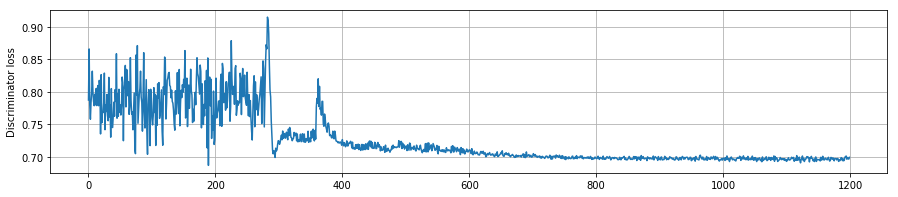

Train Generator Loss:  0.6538532629864064
Count early stop!! 17


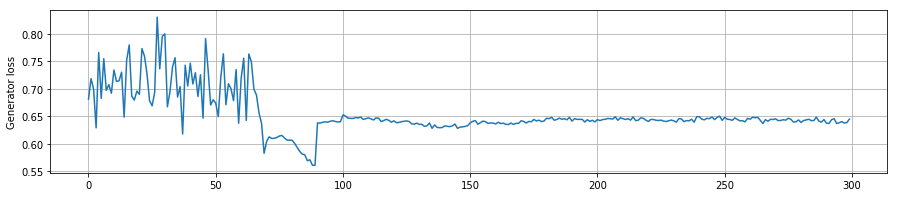

epoch 18 run to end!!
Target: <sos>這句話哪裡有bug?我也這樣虧大學同學呀<eos> Return: 謀殺案隱形眼鏡至極它跪資訊
Target: <sos>你怎麼知道裡面是真的還假的<eos> Return: 打斷意識fate迴路舉止體會
Target: <sos>五樓吃隔壁大嬸的<unk><eos> Return: 分不出至極出了名謀殺案資訊隱形眼鏡
Target: <sos>只要遇到對的話題即使70歲還是可以繼續發反串文<eos> Return: 分不出典範體會越過跪資訊惡龍鬥鬥鬥鬥隱形眼鏡鬥%隱形眼鏡隱形眼鏡?鬥40k隱形眼鏡隱形眼鏡隱形眼鏡75隱形眼鏡%隱形眼鏡75隱形眼鏡%40kfate%fate
Target: <sos>特務愛很大?<eos> Return: 至極弄掉資訊布偶手握弄掉農曆鬥鬥刁fate%隱形眼鏡
Target: <sos><unk>兄弟拍的'金錢帝國'the<unk><unk><eos> Return: 滑板流通?大量出了名鬥隱形眼鏡它兩週
Target: <sos>還ok建議選產品起碼不用輪班<eos> Return: ?矛盾?五天鬥隱形眼鏡冰水
Target: <sos>文組沒有小gg的話確定可以<eos> Return: 資訊隱形眼鏡勞健保場合弄掉隱形眼鏡但連隱形眼鏡弄掉隱形眼鏡
Target: <sos>是喔‼<eos> Return: 布偶體會體會?體會但連隱形眼鏡
Target: <sos>念什麼舊,<unk>差不多.忘不掉前任還跟現任在一起<unk>心態.浪漫別人時間<unk><eos> Return: 參加布偶打斷?隱形眼鏡迴路體會體會????不敢?
Elapsed time in epoch 18: 4481 [s]

epoch19
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 220[s]
Iteration 150(10.0%); run time: 446[s]
Iteration 225(15.0%); run time: 668[s]
Iteration 300(20.0%); run time: 893[s]
Iteration 375(25.0%); run time: 1112[s]

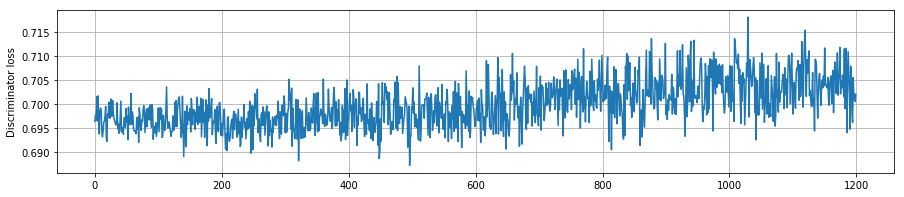

Train Generator Loss:  0.6166090814850652
Count early stop!! 18


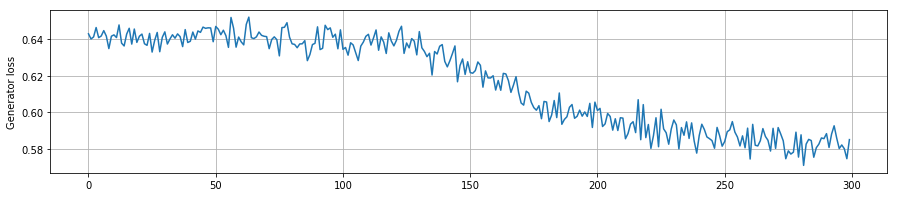

epoch 19 run to end!!
Target: <sos>塔<unk>表示,<eos> Return: 蠻強相同阿公木柵酷刑六月得到??也許也許蠟像館?戰狼?戰狼戰狼戰狼戰狼戰狼
Target: <sos>公車癡漢<eos> Return: 羨慕時空至極四月會少樣貌阿公矛盾也許也許
Target: <sos>你的<unk><unk>?<eos> Return: 敲碗阿公身分證親自要素謀殺案而成?阿公也許
Target: <sos>科技業的話,設計,討論,修改,<unk>,量產<eos> Return: 眾所幫助nov口令分不出矛盾加拿大一早戰狼至極一早
Target: <sos>不正就算了又沒特色xd<eos> Return: 還開至極病棟站內信配有阿公你會40k早睡?
Target: <sos>兩邊工時一樣當然選錢多<unk>責任制到晚上8點<eos> Return: 到哪去要素竹南至極也許也許超緊分屍戰狼一早
Target: <sos>就跟書一樣,'住在黑暗'系列似乎也只有那一集<eos> Return: 病棟四月共識?共識會少
Target: <sos>影片太模糊<eos> Return: 到哪去口令記者貼著下雨風度病棟裡頭搬也許過頭幫助戰狼怒火?也許還笑會少搬
Target: <sos>不要害人好嗎?覺得跟你交往的對象真衰<eos> Return: 口令矛盾嫖客女僕病棟騎兵嫖客嫖客會少
Target: <sos>金馬戀.avi推薦給原po<eos> Return: 至極能給站內信站內信至極站內信口令神奇es站內信會少當狗es也許怒火來黑眼圈怒火站內信
Elapsed time in epoch 19: 4465 [s]

epoch20
Iteration 1(0.07%); run time: 2[s]
Iteration 75(5.0%); run time: 216[s]
Iteration 150(10.0%); run time: 453[s]
Iteration 225(15.0%); run time: 683[s]
Iteration 300(20.0%); run time: 916[s]
Iteration 375(25.0%); run time: 1127[s]
Iteration 450(30.0%); run time

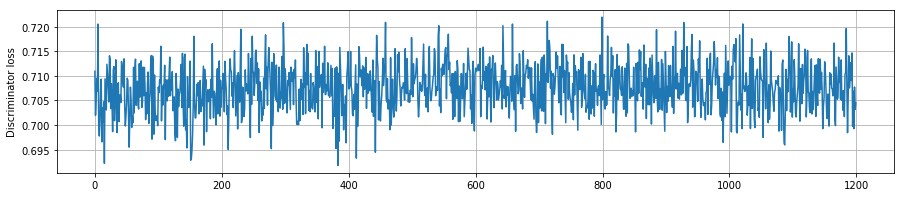

Train Generator Loss:  0.5736861008701511
Count early stop!! 19


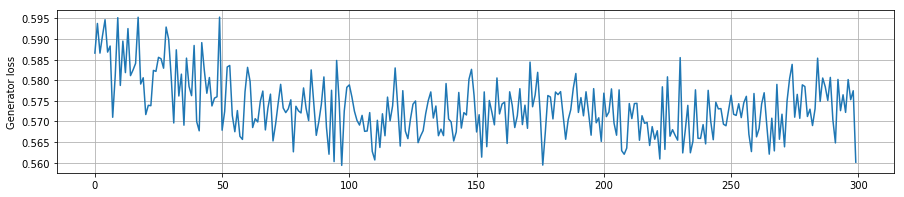

epoch 20 run to end!!
Target: <sos>好文!<unk>豪洨<eos> Return: 病棟分不出飛鳥時空至極風度至極分不出?至極至極國片也許幫助蠟像館也許至極
Target: <sos>女々しくて<eos> Return: 新年快樂再有花火屆時告誡阿公搬也許
Target: <sos>日常校園戰鬥<unk>只有第一第二集.開頭詐欺感ww<eos> Return: 三樓介時空烘了'迫害es
Target: <sos><unk>這次又要崩潰了嗎<eos> Return: 共產民國平台病棟病棟病棟病棟配有也許書
Target: <sos>推店員正直<eos> Return: 哪條手裡分不出超緊超緊幫助而成也許超緊超緊搬超緊?超緊也許站內信
Target: <sos>警察就是他.<eos> Return: 從來沒姐姐體會從來沒羊大講
Target: <sos>上廁所不會拉開來喔.太不會使用惹<unk>.不然要讓<unk>嗎xd小心<unk>褲子喔xd而且殘留的尿也會比較少<eos> Return: 交戰恭喜口令口令基友基友也許也許挺四月?也許
Target: <sos>推交往中<eos> Return: 回頭草至極裸體阿公站內信臭豆腐也許國土
Target: <sos>隔壁的<unk>,身為神之眼鏡也是吐槽全開<eos> Return: 至極打球art細緻裡頭當狗會少也許
Target: <sos>再暖都是變態懂?<eos> Return: 打球口令超緊超緊后崩業務員業務員戰狼業務員烏克
Elapsed time in epoch 20: 4499 [s]

Elapsed time in total: 89083


In [5]:
import time
import random
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.contrib import layers
import matplotlib
import matplotlib.pyplot as plt
################################################################
# Set parameter
################################################################
# batch parameter
num_epoch = 20
batch_size = 32
vocab_size = len(vocab)
num_instances = len(y_train)
iter_per_epoch = num_instances // batch_size
iter_half_epoch = iter_per_epoch // 2
test_num_instances = len(y_test)
test_iter_per_epoch = test_num_instances // batch_size
test_number = 10

# model 
limit_generation_len = max_push_length
embed_units_size = 300

# generator (seq2seq) 
g_rnn_size = 300
g_num_layers = 2
g_beam_width = 10

# discriminator (LSTM) 
d_rnn_size = 300
d_qna_layers = 2

# regularization 
lstm_dropout = 0.5
l2_reg_const = 0.001

# optimization of generator 
g_exp_decay_rate = 0.9
g_lr = 0.0001
g_clip_const = 1.0

# optimization of discriminator 
d_exp_decay_rate = 0.9
d_lr = 0.0003
d_clip_const = 1.0

# helper parameter
only_train_helper = True
cos_decay_steps = num_epoch * 1 // 10 * iter_per_epoch
decoder_start_step = num_epoch * 1 // 10 * iter_per_epoch
decoder_end_step = num_epoch * 8 // 10 * iter_per_epoch

################################################################
# Load initial weights and baises of model
################################################################
# Load Embedding model
def load_embed():
    embed_epoch = 60
    embed_name = 'PTT_Words_Embedding_1526955724.200002'
    embed_dir = os.path.join(mdl_dir, embed_name)
    if not os.path.exists(embed_dir):
        os.makedirs(embed_dir)
    
    word2vector_graph = tf.Graph()
    with tf.Session(graph=word2vector_graph) as sess:
        ######## Load model parameters ########
        # Load model and weight parameters
        load_embed_dir = os.path.join(embed_dir, 'model-{}'.format(embed_epoch))
        loader = tf.train.import_meta_graph(load_embed_dir + '.meta')
        loader.restore(sess, load_embed_dir)
        # Load named input parameters
        embeddings = word2vector_graph.get_tensor_by_name('embeddings:0').eval()
        print('Embeddings lookup shape: ', embeddings.shape)
        norm = np.sqrt(np.sum(np.square(embeddings), 1, keepdims=True))
        normal_embeddings = embeddings / norm
    return embeddings, normal_embeddings

# Load vector2word weights and baises
def load_vector2word():
    v2w_epoch = 60
    v2w_name = 'PTT_vector2word_1527011689.9644923'
    v2w_dir = os.path.join(mdl_dir, v2w_name)
    if not os.path.exists(v2w_dir):
        os.makedirs(v2w_dir)
    
    vector2word_graph = tf.Graph()
    with tf.Session(graph=vector2word_graph) as sess:
        ######## Load model parameters ########
        # Load model and weight parameters
        load_v2w_dir = os.path.join(v2w_dir, 'model-{}'.format(v2w_epoch))
        loader = tf.train.import_meta_graph(load_v2w_dir + '.meta')
        loader.restore(sess, load_v2w_dir)
        # Load named input parameters
        v2w_weights = vector2word_graph.get_tensor_by_name('v2w_weights:0').eval()
        v2w_biases = vector2word_graph.get_tensor_by_name('v2w_biases:0').eval()
    return v2w_weights, v2w_biases

################################################################
# Before model biulding
################################################################
def model_input():
    ######## model input tensor ########
    is_training = tf.placeholder(tf.bool, (), name='is_training')
    is_time_major = tf.placeholder(tf.bool, (), name='is_time_major')
    is_decoder_in = tf.placeholder(tf.bool, (), name='is_decoder_in')
    inputs = tf.placeholder(tf.int32, (None, None), name='inputs')
    input_state = tf.placeholder(tf.int32, (None, None), name='input_state')
    input_seq_len = tf.placeholder(tf.int32, (None,), name='input_seq_len')
    targets = tf.placeholder(tf.int32, (None, None), name='targets')
    target_seq_len = tf.placeholder(tf.int32, (None,), name='target_seq_len')
    max_generation_seq_len = tf.placeholder(tf.int32, (), name='max_generation_seq_len')
    input_batch_size = tf.shape(inputs)[0]
    return is_training, is_time_major, is_decoder_in, inputs, targets, input_seq_len, target_seq_len, max_generation_seq_len, input_batch_size
    
# LSTM cell
def get_rnn_cell(rnn_size, is_training=None, layer=0):
    rnn_cell = tf.contrib.rnn.LSTMCell(rnn_size, 
                initializer=tf.orthogonal_initializer(1.0, dtype=tf.float64))
    if is_training is not None and lstm_dropout < 1.0:
        if layer == 0:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, 
                                                      input_keep_prob=lstm_dropout, 
                                                      output_keep_prob=lstm_dropout)
        else:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, 
                                                      output_keep_prob=lstm_dropout)
    return rnn_cell

def embeddings_layer():
    ######## Build embedding layer weight. ########
    embeddings = tf.constant(load_embed()[0], dtype=tf.float64)
    #embeddings = tf.Variable(tf.random_uniform([vocab_size+1, embed_units_size], -1.0, 1.0, 
                                               #dtype=tf.float64),name='embeddings')
    return embeddings

################################################################
# Build generator base on seq2seq model
################################################################
def encoder_layer(inputs, input_seq_len, embeddings,
                  is_training=None, is_time_major=None, encoder_reuse=None):
    ######## Build encoder layer weight. ########
    if is_time_major is not None:
        inputs = tf.transpose(inputs, [1, 0])
        time_major_bool = True
    else:
        time_major_bool = False
    encoder_embed_input = tf.nn.embedding_lookup(embeddings, inputs)
    # Struct encoder by LSTM bi-directional multi-layer
    with tf.variable_scope("G_encoder", reuse=encoder_reuse):
        encoder_f_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(g_rnn_size, is_training, layer)
                                                      for layer in range(g_num_layers)])
        encoder_b_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(g_rnn_size, is_training, layer)
                                                      for layer in range(g_num_layers)])
        '''if input_state is not None:
            input_state_f, input_state_b = tf.split(input_state, [g_rnn_size, g_rnn_size], 1)
            encoder_bi_outputs, encoder_bi_state = tf.nn.bidirectional_dynamic_rnn(
                encoder_f_cell, encoder_b_cell, encoder_embed_input, 
                initial_state_fw=input_state_f, initial_state_bw=input_state_b,
                sequence_length=input_seq_len, dtype=tf.float64, time_major=time_major_bool)
        else:'''
        encoder_bi_outputs, encoder_bi_state = tf.nn.bidirectional_dynamic_rnn(
            encoder_f_cell, encoder_b_cell, encoder_embed_input, 
            sequence_length=input_seq_len, dtype=tf.float64, time_major=time_major_bool)
    encoder_outputs = tf.concat((encoder_bi_outputs[0], encoder_bi_outputs[1]), 2)
    #encoder_state = tf.concat((encoder_bi_state[0], encoder_bi_state[1]), 2)
    encoder_state = tuple([tf.contrib.rnn.LSTMStateTuple(tf.concat((state_f.c, state_b.c), 1), 
                                                          tf.concat((state_f.h, state_b.h), 1))
                     for state_f, state_b in zip(encoder_bi_state[0], encoder_bi_state[1])])
    '''print(encoder_outputs)
    print(encoder_state)
    print(encoder_bi_outputs)
    print(encoder_bi_state)'''
    
    return encoder_outputs, encoder_state

def attention_layer(encoder_outputs, encoder_state, 
                    input_seq_len, input_batch_size,
                    is_training=None, is_time_major=None):
    ######## Build attention layer weight. ########
    if is_time_major is not None:
        encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])
    
    # Struct LSTM cell in Decoder
    with tf.name_scope('G_decoder'):
        multi_rnn_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(g_rnn_size*2, is_training, layer)
                                                    for layer in range(g_num_layers)])
        '''# For beam search decoder
        encoder_outputs = tf.contrib.seq2seq.tile_batch(
            encoder_outputs, multiplier=g_beam_width)
        input_seq_len = tf.contrib.seq2seq.tile_batch(
            input_seq_len, multiplier=g_beam_width)
        encoder_state = tf.contrib.seq2seq.tile_batch(
            encoder_state, multiplier=g_beam_width)
        input_batch_size = input_batch_size * g_beam_width
        '''
        #attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(g_rnn_size*2, encoder_outputs,
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(g_rnn_size*2, encoder_outputs,
                                                                memory_sequence_length=input_seq_len,
                                                                dtype=tf.float64)
        decoder_cell = tf.contrib.seq2seq.AttentionWrapper(multi_rnn_cell, 
                                                           attention_mechanism, 
                                                           attention_layer_size=g_rnn_size)
        decoder_ini_state = decoder_cell.zero_state(input_batch_size,
                                                    tf.float64).clone(cell_state=encoder_state)
    return decoder_ini_state, decoder_cell

'''def decoder_layer(is_training, is_decoder_in, is_time_major, 
                  targets, target_seq_len, max_generation_seq_len, 
                  decoder_ini_state, decoder_cell, 
                  input_batch_size, embeddings):
    if is_time_major is not None:
        time_major_bool = True
    else:
        time_major_bool = False
    
    # Output fully-connecting layer
    projection_layer = Dense(vocab_size+1, use_bias=False,
                         kernel_initializer=tf.truncated_normal_initializer(
                             mean=0.0, stddev=0.1, dtype=tf.float64))
    
    # Struct training decoder (Share variable with predicting)
    start_tokens = tf.tile(tf.constant([vocab[SOS_id]], dtype=tf.int32),
                           [input_batch_size * g_beam_width], name='start_tokens')
    # Define a beam-search decoder
    rnn_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
        cell=decoder_cell,
        embedding=embeddings,
        start_tokens=start_tokens,
        end_token=vocab[EOS_id],
        initial_state=decoder_initial_state,
        g_beam_width=g_beam_width,
        projection_layer=projection_layer,
        length_penalty_weight=0.0)
    
    decoder_output, _, training_seq_len = tf.contrib.seq2seq.dynamic_decode(
        rnn_decoder, impute_finished=True, maximum_iterations=max_generation_seq_len)
    
    translations = outputs.predicted_ids
    # Make sure translations shape is [batch_size, g_beam_width, time]
    if is_time_major is not None:
        translations = tf.transpose(translations, perm=[1, 2, 0])

    ######## Model output tensor ########
    training_logits = tf.identity(decoder_output.rnn_output, name='training_logits')
    training_ids = tf.identity(decoder_output.sample_id, name='training_ids')
    max_training_seq_len = tf.reduce_max(training_seq_len)
    return training_logits, training_ids, max_training_seq_len'''

def decoder_layer(targets, target_seq_len, max_generation_seq_len, 
                  decoder_ini_state, decoder_cell, 
                  input_batch_size, embeddings,
                  is_training=None, is_time_major=None, is_decoder_in=None):
    ######## Build decoder layer weight. ########
    if is_time_major is not None:
        time_major_bool = True
    else:
        time_major_bool = False
    
    # Output fully-connecting layer
    v2w_weights, v2w_biases = load_vector2word()
    projection_layer = Dense(vocab_size+1,
                             kernel_initializer=tf.constant_initializer(
                                 v2w_weights, dtype=tf.float64), 
                             bias_initializer=tf.constant_initializer(
                                 v2w_biases, dtype=tf.float64),
                             trainable=False)
    with tf.name_scope('G_decoder'):
        # Struct training decoder (Share variable with predicting)
        if is_decoder_in is not None:
            if is_time_major is not None:
                targets = tf.transpose(targets, [1, 0])
            decoder_embed_input = tf.nn.embedding_lookup(embeddings, targets)
            training_helper = tf.contrib.seq2seq.TrainingHelper(
                decoder_embed_input, target_seq_len, time_major=time_major_bool)
        else:
            start_tokens = tf.tile(tf.constant([vocab[SOS_id]], dtype=tf.int32),
                                   [input_batch_size], name='start_tokens')
            training_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                embeddings, start_tokens, vocab[EOS_id])

        training_decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, training_helper, decoder_ini_state, projection_layer) 
        training_output, decoder_state, training_seq_len = tf.contrib.seq2seq.dynamic_decode(
            training_decoder, impute_finished=True, maximum_iterations=max_generation_seq_len)
    
    ######## Model output tensor ########
    training_logits = tf.identity(training_output.rnn_output, name='training_logits')
    training_ids = tf.identity(training_output.sample_id, name='training_ids')
    return training_logits, training_ids, training_seq_len, decoder_state

def seq2seq_generator(embeddings, input_batch_size, 
                      inputs, input_seq_len, 
                      targets, target_seq_len, max_generation_seq_len,
                      is_training=None, is_time_major=None, is_decoder_in=None):
    encoder_outputs, encoder_state = encoder_layer(
        inputs, input_seq_len, embeddings,
        is_training, is_time_major)
    decoder_ini_state, decoder_cell = attention_layer(
        encoder_outputs, encoder_state, 
        input_seq_len, input_batch_size,
        is_training, is_time_major)
    training_logits, training_ids, training_seq_len, decoder_state = decoder_layer(
        targets, target_seq_len, max_generation_seq_len, 
        decoder_ini_state, decoder_cell, 
        input_batch_size, embeddings,
        is_training, is_time_major, is_decoder_in)
    return training_logits, training_ids, training_seq_len, decoder_state

################################################################
# Build discriminator base on LSTM model
################################################################
def qna_rnn_layer(input_q, input_a, is_training=None, qna_reuse=None):
    input_dialog = [input_q, input_a]
    
    with tf.variable_scope('D_qna', reuse=qna_reuse):
        qna_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(d_rnn_size*2, is_training, layer)
                                                for layer in range(d_qna_layers)])
        qna_output, _ = tf.nn.static_rnn(qna_cell, input_dialog, dtype=tf.float64)
        # Output fully-connecting layer
        logits_output = tf.layers.dense(qna_output[-1], 1,
                                       kernel_initializer=tf.truncated_normal_initializer(
                                           mean=0.0, stddev=0.1, dtype=tf.float64))
    return logits_output
    
def rnn_discriminator(embeddings, input_batch_size, 
                      inputs, input_seq_len, 
                      targets, target_seq_len, max_generation_seq_len,
                      is_training=None, is_time_major=None, is_decoder_in=None, d_reuse=None):
    outputs_q, state_q = encoder_layer(inputs, input_seq_len, embeddings,
                                       is_training, is_time_major, True)
    outputs_a, state_a = encoder_layer(targets, target_seq_len, embeddings, 
                                       is_training, is_time_major, True)
    output_q = state_q[-1].h
    output_a = state_a[-1].h
    d_logit = qna_rnn_layer(output_q, output_a, is_training, d_reuse)
    return d_logit

################################################################
# GAN model
################################################################
def GAN_model(embeddings, input_batch_size, 
              inputs, input_seq_len, 
              targets, target_seq_len, max_generation_seq_len,
              is_training=None, is_time_major=None, is_decoder_in=None):
    _, training_ids, training_seq_len, _ = seq2seq_generator(
        embeddings, input_batch_size, 
        inputs, input_seq_len, 
        targets, target_seq_len, max_generation_seq_len,
        is_training, is_time_major, is_decoder_in)
    fake_score = rnn_discriminator(
        embeddings, input_batch_size, 
        inputs, input_seq_len,
        training_ids, training_seq_len, max_generation_seq_len,
        is_training, is_time_major, is_decoder_in)
    real_score = rnn_discriminator(
        embeddings, input_batch_size, 
        inputs, input_seq_len,
        targets, target_seq_len, max_generation_seq_len,
        is_training, is_time_major, is_decoder_in, True)
    return training_ids, fake_score, real_score

################################################################
# Training model
################################################################
def loss_function(fake_score, real_score):
    ######## Build loss function ########
    # Two Loss Functions for discriminator
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=fake_score, labels=tf.zeros_like(fake_score)), name='d_fake_loss')
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=real_score, labels=tf.ones_like(real_score)), name='d_real_loss')
    # Loss function for generator
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=fake_score, labels=tf.ones_like(fake_score)), name='g_loss')
    return d_fake_loss, d_real_loss, g_loss
    
def update_step():
    ######## Build optimization ########
    # Update step
    global_step = tf.Variable(0, trainable=False)
    d_learning_rate = tf.train.exponential_decay(
        d_lr, global_step, iter_per_epoch, d_exp_decay_rate, staircase=False)
    g_learning_rate = tf.train.exponential_decay(
        g_lr, global_step, iter_per_epoch, g_exp_decay_rate, staircase=False)
    global_step = global_step + 1
    
    # Get the varaibles for different network
    tvars = tf.trainable_variables()
    d_vars = [var for var in tvars if 'D_' in var.name]
    g_vars = [var for var in tvars if 'G_' in var.name]
    return d_learning_rate, g_learning_rate, d_vars, g_vars
    
def optimization(loss, learning_rate, train_vars, clip_const):
    ######## Build optimization ########
    loss_l2 = tf.Variable(0.0, trainable=False, dtype=tf.float64)
    
    # Regularization, Optimizer & Gradient Clipping for discriminator fake
    loss_l2 = l2_reg_const * sum(
        tf.nn.l2_loss(var) for var in train_vars)
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-12)
    gradients, vriables = zip(*optimizer.compute_gradients(loss+loss_l2, var_list=train_vars))
    gradients = [None if gradient is None else tf.clip_by_norm(gradient, clip_const)
                   for gradient in gradients]
    train_step = optimizer.apply_gradients(
        zip(gradients, vriables), name='train_step')
    return train_step

################################################################
# Prepare to run session
################################################################
build_new_model = True
patience = 0
total_start_t = time.time()
if build_new_model:
    str_epoch = 0
    decoder_global_step = 0
    model_name = 'PTT_one_push_s2s_GAN_model_fixed_' + str(total_start_t)
else:
    str_epoch = 8
    decoder_global_step = str_epoch * iter_per_epoch
    model_name = 'PTT_one_push_s2s_GAN_model_fixed_1527216723.8142333'

model_dir = os.path.join(mdl_dir, model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
iter_pct = iter_per_epoch // 20
if (num_instances % batch_size) > 0:
    iter_per_epoch += 1
batch_cutoff = [0]
for i in range(iter_per_epoch):
    batch_cutoff.append(batch_size * (i+1))
batch_cutoff.append(num_instances)
d_costs_list = []
g_costs_list = []

d_train_len = 40
g_train_len = 10
d_best_costs_mean = 0.0
g_best_costs_mean = 0.0
d_early_stop_counter = 0
g_early_stop_counter = 0
d_last_loss = 0.0
g_last_loss = 0.0
is_training_generator = False
train_len = d_train_len
train_count = 0

################################################################
# Run model session
################################################################
train_graph = tf.Graph()
if build_new_model:
    ######## Build model parameters ########
    with train_graph.as_default():
        # Build input parameters
        is_training, is_time_major, is_decoder_in, inputs, targets, input_seq_len, target_seq_len, max_generation_seq_len, input_batch_size = model_input()
        # Build model and weight parameters
        embeddings = embeddings_layer()
        training_ids, fake_score, real_score = GAN_model(
            embeddings, input_batch_size, 
            inputs, input_seq_len, 
            targets, target_seq_len, max_generation_seq_len,
            is_training, is_time_major, is_decoder_in)
        # Build optimizer
        d_fake_loss, d_real_loss, g_loss = loss_function(fake_score, real_score)
        d_learning_rate, g_learning_rate, d_vars, g_vars = update_step()
        with tf.name_scope('d_fake_train'):
            d_fake_train_step = optimization(d_fake_loss, d_learning_rate, d_vars, d_clip_const)
        with tf.name_scope('d_real_train'):
            d_real_train_step = optimization(d_real_loss, d_learning_rate, d_vars, d_clip_const)
        with tf.name_scope('g_train'):
            g_train_step = optimization(g_loss, g_learning_rate, g_vars, g_clip_const)

with tf.Session(graph=train_graph) as sess:
    if build_new_model:
        sess.run(tf.global_variables_initializer())
        best_epoch = 1
    else:
        ######## Load model parameters ########
        # Load model and weight parameters
        best_epoch = str_epoch
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        is_training = train_graph.get_tensor_by_name('is_training:0')
        is_decoder_in = train_graph.get_tensor_by_name('is_decoder_in:0')
        is_time_major = train_graph.get_tensor_by_name('is_time_major:0')
        inputs = train_graph.get_tensor_by_name('inputs:0')
        targets = train_graph.get_tensor_by_name('targets:0')
        input_seq_len = train_graph.get_tensor_by_name('input_seq_len:0')
        target_seq_len = train_graph.get_tensor_by_name('target_seq_len:0')
        max_generation_seq_len = train_graph.get_tensor_by_name('max_generation_seq_len:0')
        # Load named output and optimizer parameters
        training_logits = train_graph.get_tensor_by_name('training_logits:0')
        training_ids = train_graph.get_tensor_by_name('training_ids:0')
        d_fake_loss = train_graph.get_tensor_by_name('d_fake_loss:0')
        d_real_loss = train_graph.get_tensor_by_name('d_real_loss:0')
        g_loss = train_graph.get_tensor_by_name('g_loss:0')
        d_fake_train_step = train_graph.get_operation_by_name('d_fake_train/train_step')
        d_real_train_step = train_graph.get_operation_by_name('d_real_train/train_step')
        g_train_step = train_graph.get_operation_by_name('g_train/train_step')
        
    ######## Run model epoch ########
    for e in range(str_epoch,str_epoch+num_epoch):
        rand_idxs = np.random.permutation(num_instances)
        print('\n========')
        print('epoch' + str(e+1))
        print('========')
        start_t = time.time()
        d_costs = []
        g_costs = []
        
        ######## Get random input batch and training model. ########
        for i in range(iter_per_epoch):
            train_count += 1
            if train_count >= train_len:
                train_count = 0
                is_training_generator = not is_training_generator
                if is_training_generator:
                    train_len = g_train_len
                else:
                    train_len = d_train_len
            
            X_batch = []
            Y_batch = []
            X_size = []
            Y_size = []
            for n in range(batch_cutoff[i],batch_cutoff[i+1]):
                X_batch.append(x_train[rand_idxs[n]])
                Y_batch.append(y_train[rand_idxs[n]])
                X_size.append(x_train_size[rand_idxs[n]])
                Y_size.append(y_train_size[rand_idxs[n]])
            X_size_max = max(X_size)
            Y_size_max = max(Y_size)
            X_batch = np.array(X_batch)
            Y_batch = np.array(Y_batch)
            X_size = np.array(X_size)
            Y_size = np.array(Y_size)

            # Select helper based on learning time.
            decoder_global_step +=1
            
            if is_training_generator:
                training_name = 'Generator'
                feed_dict = {is_training: True, is_decoder_in: True, is_time_major: True,
                    inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                    input_seq_len: X_size, target_seq_len: Y_size,
                    max_generation_seq_len: limit_generation_len}
                if (i+1) % iter_pct == 0 or i == 0:
                    _, this_loss, output_ids = sess.run(
                        [g_train_step, g_loss, training_ids], feed_dict)
                else:
                    _, this_loss = sess.run(
                        [g_train_step, g_loss], feed_dict)
                g_costs.append(this_loss)
                g_last_loss = this_loss
            else:
                feed_dict = {is_training: True, is_time_major: True,
                    inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                    input_seq_len: X_size, target_seq_len: Y_size,
                    max_generation_seq_len: limit_generation_len}
                training_name = 'Discriminator'
                if (i+1) % iter_pct == 0 or i == 0:
                    _, _,  this_real_loss, this_fake_loss, output_ids = sess.run(
                        [d_fake_train_step, d_real_train_step, d_fake_loss, d_real_loss, training_ids], feed_dict)
                else:
                    _, _, this_real_loss, this_fake_loss = sess.run(
                        [d_fake_train_step, d_real_train_step, d_fake_loss, d_real_loss], feed_dict)
                this_loss = (this_real_loss + this_fake_loss)/2.0
                d_costs.append(this_loss)
                d_last_loss = this_loss

            if np.isnan(this_loss):
                print('\n!!!! The', training_name, 'Loss is NaN! !!!!')
                print('NaN epoch: ', e, ' ; NaN iteration: ', i+1)
                print('Stop decoder_global_step: ', decoder_global_step)
                print('The last discriminator loss: ', d_last_loss)
                print('The last generator loss: ', g_last_loss)
                break

            if (i+1) % iter_pct == 0 or i == 0:
                log = 'Iteration {}({}%); run time: {}[s]'.format(
                    str(i+1), str(round((i+1)*100/iter_per_epoch,2)),
                    str(int(time.time() - start_t)))
                print(log)
                log += '\n'
                for batch_index in range(batch_size):
                    log += 'Target: {}'.format("".join([vocab_reverse[i] for i in Y_batch[batch_index] if i != 0]))
                    log += '; Return: {}'.format("".join([vocab_reverse[i] for i in output_ids[batch_index] if i != 0]))
                    log += '\n'
                else:
                    with open(os.path.join(model_dir, 'Target_Return.txt'),
                            'a', encoding = 'utf-8-sig') as file:
                        file.write('Epoch' + str(e+1) + '\n' + 'Iteration' + str(i+1) + '\n' + log + '\n')
        
        ######## Print discriminator cost curve of this epoch. ########
        costs_mean = np.array(d_costs).mean()
        d_costs_list.append(d_costs)
        print('Train Discriminator Loss: ', costs_mean)
        if costs_mean < d_best_costs_mean or e == 0:
            d_best_costs_mean = costs_mean
            best_epoch = e
            d_early_stop_counter = 0
            print('Save the best disciminator score!! '+str(d_best_costs_mean))
        else:
            d_early_stop_counter += 1
            print('Count early stop!! '+str(d_early_stop_counter))
        plt.figure(figsize=(15,3))
        plt.plot(d_costs)
        plt.ylabel('Discriminator loss')
        plt.grid()
        plt.show()
        d_costs = []
        
        ######## Print generator cost curve of this epoch. ########
        costs_mean = np.array(g_costs).mean()
        g_costs_list.append(g_costs)
        print('Train Generator Loss: ', costs_mean)
        if costs_mean < g_best_costs_mean or e == 0:
            g_best_costs_mean = costs_mean
            best_epoch = e
            g_early_stop_counter = 0
            print('Save the best generator score!! '+str(g_best_costs_mean))
        else:
            g_early_stop_counter += 1
            print('Count early stop!! '+str(g_early_stop_counter))
        plt.figure(figsize=(15,3))
        plt.plot(g_costs)
        plt.ylabel('Generator loss')
        plt.grid()
        plt.show()
        g_costs = []
        
        ######## Generate title form testing content and validating model. ########
        print('epoch ' + str(e+1) + ' run to end!!')
        Xt_batch = []
        Yt_batch = []
        Xt_size = []
        for _ in range(test_number):
            n = random.randint(0, test_num_instances-1)
            Xt_batch.append(x_test[n])
            Yt_batch.append(y_test[n])
            Xt_size.append(x_test_size[n])
        Xt_size_max = max(Xt_size)
        Xt_batch = np.array(Xt_batch)
        Yt_batch = np.array(Yt_batch)
        Xt_size = np.array(Xt_size)
        
        feed_dict = {is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     max_generation_seq_len: limit_generation_len}
        answer_ids = sess.run(training_ids, feed_dict)
        for n in range(test_number):
            log = 'Target: {}'.format("".join([vocab_reverse[i] for i in Yt_batch[n] if i != 0]))
            print(log + ' Return: {}'.format("".join([vocab_reverse[i] for i in answer_ids[n] if i != 0])))
        
        ######## Save model weight parameters and information. ########
        model_path = os.path.join(model_dir, 'model-%d' %(e+1))
        saver = tf.train.Saver()
        saver.save(sess, model_path)
        
        print('Elapsed time in epoch ' + str(e+1) + ': ' + str(int(time.time() - start_t)) + ' [s]')
        
        if patience != 0 and d_early_stop_counter >= patience and g_early_stop_counter >= patience:
            print('\n#######')
            print('Best model')
            print('#######')
            print('Stop by early stopping')
            print('Best discriminator score: ', d_best_costs_mean)
            print('Best generator score: ', g_best_costs_mean)
            print('Beat model: ', best_epoch)
            break

print('\nElapsed time in total: ' + str(int(time.time() - total_start_t)))

In [7]:
import os
import random
################################
#Generate title form testing content and validating model. 
################################
base_dir = 'E:/Raw data/PTT'
model_name = 'PTT_one_push_s2s_GAN_model_fixed_1527507863.8109949'
epoch = 20
model_path = os.path.join(base_dir, 'model', model_name, 'model-{}'.format(epoch))
print('Test epoch: ', epoch)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(model_path + '.meta')
    loader.restore(sess, model_path)
    # Named parameters
    # Load named input parameters
    is_training = loaded_graph.get_tensor_by_name('is_training:0')
    is_decoder_in = loaded_graph.get_tensor_by_name('is_decoder_in:0')
    is_time_major = loaded_graph.get_tensor_by_name('is_time_major:0')
    inputs = loaded_graph.get_tensor_by_name('inputs:0')
    targets = loaded_graph.get_tensor_by_name('targets:0')
    input_seq_len = loaded_graph.get_tensor_by_name('input_seq_len:0')
    target_seq_len = loaded_graph.get_tensor_by_name('target_seq_len:0')
    max_generation_seq_len = loaded_graph.get_tensor_by_name('max_generation_seq_len:0')
    # Load named output and optimizer parameters
    training_logits = loaded_graph.get_tensor_by_name('training_logits:0')
    training_ids = loaded_graph.get_tensor_by_name('training_ids:0')
    d_fake_loss = loaded_graph.get_tensor_by_name('d_fake_loss:0')
    d_real_loss = loaded_graph.get_tensor_by_name('d_real_loss:0')
    g_loss = loaded_graph.get_tensor_by_name('g_loss:0')
    d_fake_train_step = loaded_graph.get_operation_by_name('d_fake_train/train_step')
    d_real_train_step = loaded_graph.get_operation_by_name('d_real_train/train_step')
    g_train_step = loaded_graph.get_operation_by_name('g_train/train_step')
        
    for _ in range(10):
        i_str = random.randint(0,test_num_instances-1)
        i_end = i_str + 1

        X_batch = np.tile(x_test[i_str], (batch_size, 1))
        Y_batch = np.tile(y_test[i_str], (batch_size, 1))
        X_size = np.tile(x_test_size[i_str], (batch_size))
        Y_size = np.tile(y_test_size[i_str], (batch_size))
        X_size_max = x_test_size[i_str]
        Y_size_max = y_test_size[i_str]
        '''answer_ids = sess.run( logits, {inputs: X_batch, targets: Y_batch, 
                                             input_seq_len: X_size, target_seq_len: Y_size,
                                             max_generation_seq_len: limit_generation_len})'''
        feed_dict = {is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     max_generation_seq_len: limit_generation_len}
        answer_ids = sess.run(training_ids, feed_dict)

        output_index = 0 #random.randint(0,batch_size-1)
        print('\n========')
        print('Test index: ', i_str + output_index)
        print('========')
        print('Test input Words: {}'.format("".join([vocab_reverse[i] for i in X_batch[output_index] if i != 0])))
        print('Target Words: {}'.format("".join([vocab_reverse[i] for i in Y_batch[output_index] if i != 0])))
        print('Response Words: {}'.format("".join([vocab_reverse[i] for i in answer_ids[output_index] if i != 0])))

Test epoch:  20
INFO:tensorflow:Restoring parameters from E:/Raw data/PTT\model\PTT_one_push_s2s_GAN_model_fixed_1527507863.8109949\model-20

Test index:  5506
Test input Words: <sos>.'有<unk>'.其實從這張圖來看.可以發現<unk><unk>約20幾公分吧.可以當作<unk>的<unk>是<unk>.<unk>會濕,但不至於<unk><unk>.也沒有違反<unk>的問題.單純踩在有<unk>滿足客人想像要求這樣.是說這部作畫真的美!.<eos>
Target Words: <sos>實戰最接近薇<unk><unk>回家<unk>的應該是<unk>的空中<unk>秒<unk>竟然穿長裙在跑.據我<unk>的<unk><eos>
Response Words: 貼著女僕至極910大考大考超緊怒火當狗不賣剪片嫖客意識?也許??幫助五天嫖客怒火當狗怒火幫助也許戰狼?也許幫助也許

Test index:  9716
Test input Words: <sos>.小時候常常會被要求也長大的夢想這類作文.我的夢想就是<unk>像蠟筆小新他們家的房子.有<unk>可以種花養狗,有自己的廚房可以烤蛋糕,餅乾.衛浴分離,還有可以自己佈置自己的房間.沒想到出社會後,我只買得起大樓的其中一間'考慮工作位置'.貸款<unk>差不多qq.還有小時候夢想的工作,才發現有性別的<unk>規矩.不知道各位有沒有實現小時候的夢想?.<eos>
Target Words: <sos><unk>還得兼行政.好慘.哀.<eos>
Response Words: 想法兩面民國再有裡頭會少病棟剪片?早睡裡頭

Test index:  9300
Test input Words: <sos>.前一陣子我到朋友家玩.因為他們家搬到<unk>案,所以裡面的保全設備超完善的.像是<unk><unk>,瓦斯偵測等等都有.其實看了有點心動.不過我們家是舊公寓,不知道裝起來會不會很麻煩.而且感覺裝下去又是一筆錢.不久前有去新光保全開的展示間看.裡面展示的東西感覺都不錯,但是看完後還是有點猶豫.大家會推薦裝保全系統嗎?.<eos>
